## 1. Building ENM 

In [18]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from prody import *
from pylab import *
import Bio.PDB
from scipy.stats import pearsonr
from scipy.spatial import distance
from MDAnalysis.analysis import distances
from scipy.linalg import fractional_matrix_power
from scipy.optimize import minimize
from numpy import diff
import pandas as pd

In [19]:
file_dir = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/"
#pdb = "/scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/confout_1.gro"
pdb = file_dir+"confout_1.gro"
u = mda.Universe(pdb, pdb)
CA = u.select_atoms('name CA')
n_res = CA.n_residues
spring_constant = 1
temperature = 310
RT = temperature*8.314/1000

In [20]:
def get_positions(CA):
    positions = CA.positions/10 # In nano meters
    distance_map = distance.cdist(positions, positions)
    distance_map = np.repeat(np.repeat(distance_map, 3, axis=1), 3, axis=0)
    inv_distsq_map = distance_map**-2
    inv_distsq_map[inv_distsq_map == np.inf] = 0
    return positions, distance_map, inv_distsq_map

def get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant):
    kirchoff_matrix = np.ones((n_res*3, n_res*3))
    kirchoff_matrix[distance_map>cutoff] = 0
    kirchoff_matrix = spring_constant*kirchoff_matrix
    return kirchoff_matrix

def get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res):
    xx_distance_map = distance.cdist(positions[:, 0].reshape(-1, 1), positions[:, 0].reshape(-1, 1), lambda u, v: u-v)
    yy_distance_map = distance.cdist(positions[:, 1].reshape(-1, 1), positions[:, 1].reshape(-1, 1), lambda u, v: u-v)
    zz_distance_map = distance.cdist(positions[:, 2].reshape(-1, 1), positions[:, 2].reshape(-1, 1), lambda u, v: u-v)

    H = np.zeros((n_res*3, n_res*3))
    H[0::3, 0::3] = xx_distance_map * xx_distance_map
    H[1::3, 1::3] = yy_distance_map * yy_distance_map
    H[2::3, 2::3] = zz_distance_map * zz_distance_map
    H[0::3, 1::3] = xx_distance_map * yy_distance_map
    H[0::3, 2::3] = xx_distance_map * zz_distance_map
    H[1::3, 2::3] = yy_distance_map * zz_distance_map
    H[1::3, 0::3] = xx_distance_map * yy_distance_map
    H[2::3, 0::3] = xx_distance_map * zz_distance_map
    H[2::3, 1::3] = yy_distance_map * zz_distance_map
    H = -1 * kirchoff_matrix * inv_distsq_map * H

    for i in range(n_res):
        H[i*3+0, i*3+0] = -1*np.sum(H[i*3+0, 0::3])
        H[i*3+1, i*3+1] = -1*np.sum(H[i*3+1, 1::3])
        H[i*3+2, i*3+2] = -1*np.sum(H[i*3+2, 2::3])
        H[i*3+0, i*3+1] = -1*np.sum(H[i*3+0, 1::3])
        H[i*3+1, i*3+0] = H[i*3+0, i*3+1]
        H[i*3+0, i*3+2] = -1*np.sum(H[i*3+0, 2::3])
        H[i*3+2, i*3+0] = H[i*3+0, i*3+2]
        H[i*3+1, i*3+2] = -1*np.sum(H[i*3+1, 2::3])
        H[i*3+2, i*3+1] = H[i*3+1, i*3+2]  
    return H

def get_mass_matrix(CA):
    residue_mass = CA.residues.masses/1000
    residue_mass = np.repeat(residue_mass, 3)
    M = np.diag(residue_mass)
    M_f = fractional_matrix_power(M, -0.5)
    return M_f

def get_mass_weighted_H(M_f, H):
    H_m = (M_f@H)@M_f
    return H_m

def get_fluctuations(M_f, H_m, RT):
    [v, U_m] = np.linalg.eig(H_m)
    U_m = U_m[:, np.argsort(v)]
    v = v[np.argsort(v)]
    U_m = U_m.astype('float64')
    M_f = M_f.astype('float64')
    v = v.astype('float64')
    m = len(H_m[0])
    C = np.zeros((np.shape(H_m)))
    for i in range(len(v)-6):
        C += (np.outer((M_f@U_m[:, i+6]), U_m[:, i+6].T)@M_f)/v[i+6]
    C = RT*C
    sq_fluctuations = np.diag(C).reshape(-1,3).sum(axis=1)
    F = np.sqrt(sq_fluctuations)
    return sq_fluctuations, F

In [21]:
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
def fluctuations(CA, n_res, cutoff, spring_constant):
    kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
    H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
    H_m = get_mass_weighted_H(M_f, H)
    sq_fluctuations, F = get_fluctuations(M_f, H_m, RT)
    return sq_fluctuations, F

/var/tmp/pbs.3547524.pbshpc/ipykernel_23566/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


In [22]:
rmsf_L = np.genfromtxt(file_dir+'rmsf_chL.xvg', skip_header=17)[:, 1]
rmsf_H = np.genfromtxt(file_dir+'rmsf_chH.xvg', skip_header=17)[:, 1]
rmsf = np.hstack((rmsf_L, rmsf_H))*10

In [23]:
cutoff = range(9, 20)
pearson_corr = []
for Rc in cutoff:
    sq_fluctuations_P, F_P = fluctuations(CA, n_res, Rc/10, spring_constant)
    corr, _ = pearsonr(rmsf, F_P)
    pearson_corr.append(corr)

In [24]:
pearson_corr

[0.7203016285604361,
 0.7612463886669106,
 0.6743595651426956,
 0.7043624666222019,
 0.7165421875253262,
 0.7052278669934748,
 0.7158173823778486,
 0.7051377884888738,
 0.6938855487257857,
 0.692463141621529,
 0.6786296950684103]

Maximum pearson coefficient is 0.7612463886669106 at:  1.0 nanoseconds


Text(0, 0.5, 'Pearson Coefficient')

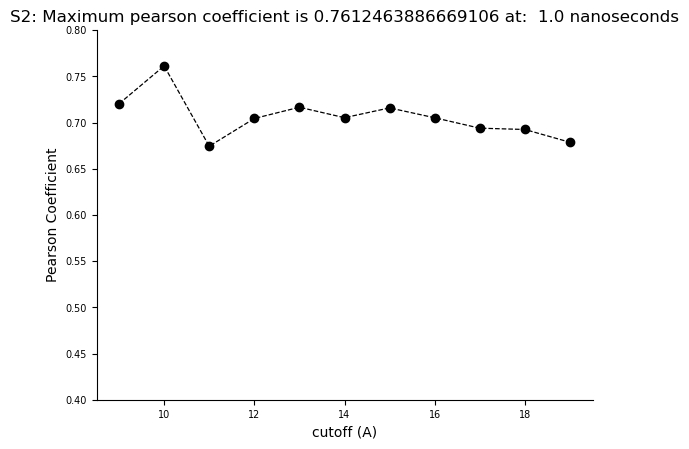

In [25]:
# With my 1ns rmsf
index = pearson_corr.index(max(pearson_corr))
opt_Rc = cutoff[index]/10
print('Maximum pearson coefficient is', max(pearson_corr), 'at: ', opt_Rc, 'nanoseconds')
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0.4, 0.8)
plt.title("S2: Maximum pearson coefficient is 0.7612463886669106 at:  1.0 nanoseconds")
plt.xlabel("cutoff (A)", fontsize = 10)
plt.ylabel("Pearson Coefficient", fontsize = 10)

Text(0, 0.5, 'Sq fluctuations (A2)')

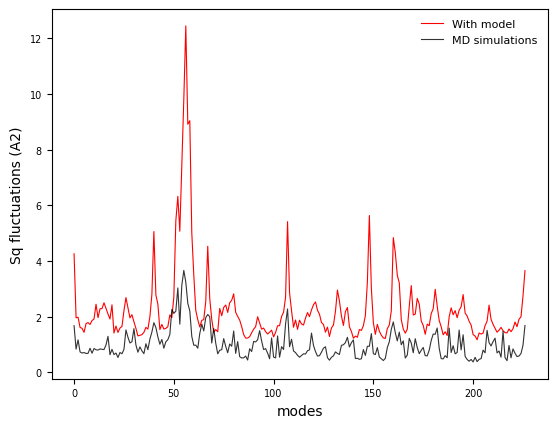

In [26]:
sq_fluctuations, F = fluctuations(CA, n_res, opt_Rc, spring_constant)
plt.plot(F, label = "With model", color = 'red', linewidth=0.8)
plt.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

In [27]:
scale = (sq_fluctuations.mean()/rmsf.mean()**2)
print('The scale (kJ/A^2)is:', scale)

The scale (kJ/A^2)is: 6.989206268480202


In [28]:
spring_constant = spring_constant*scale
sq_fluctuations_scale, F_scale = fluctuations(CA, n_res, opt_Rc, spring_constant)

Text(0, 0.5, 'Sq fluctuations (A2)')

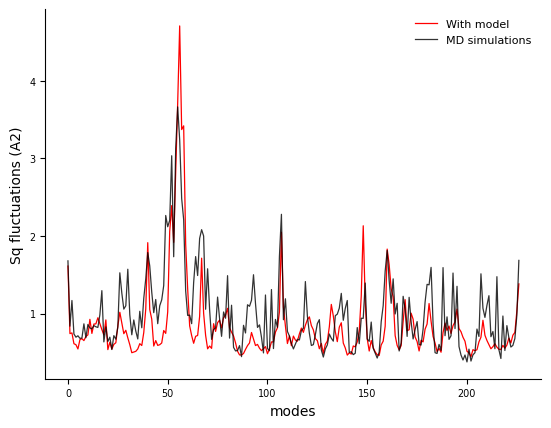

In [29]:
ax = plt.subplot()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
ax.plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, prop={'size':8})
#plt.title("Comparing fluctuations: ENM vs MD simulation")
plt.xlabel("modes", fontsize = 10)
plt.ylabel("Sq fluctuations (A2)", fontsize = 10)

Text(-50, 2, 'C')

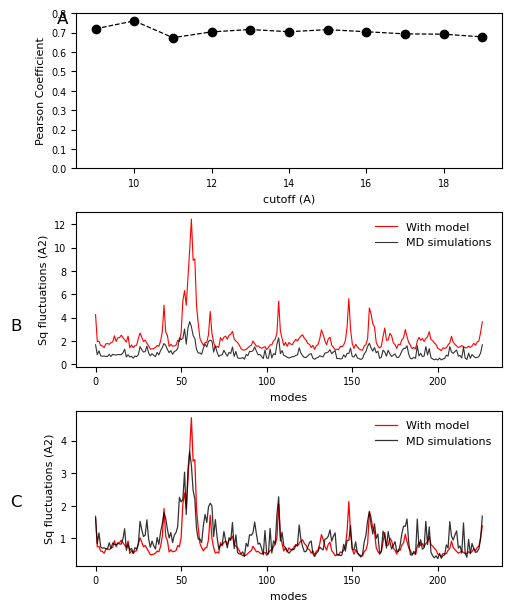

In [30]:
fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 6), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[1].plot(F, label = "With model", color = 'red', linewidth=0.8)
axes[1].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.8)
axes[1].legend(frameon = False, prop={'size':8})
axes[1].set_xlabel("modes", fontsize = 8)
axes[1].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[1].text(-50, 2.9, "B", fontsize = 12)
axes[0].plot(cutoff, pearson_corr, marker='o', linestyle='--', color = 'black', linewidth = 0.9)
axes[0].set_ylim(0, 0.8)
axes[0].text(8, 0.75, "A", fontsize = 12)
axes[0].set_xlabel("cutoff (A)", fontsize = 8)
axes[0].set_ylabel("Pearson Coefficient", fontsize = 8)
axes[2].plot(F_scale, label = "With model", color = 'red', linewidth=0.9)
axes[2].plot(rmsf, label = "MD simulations", color = 'black', alpha=0.8, linewidth=0.9)
axes[2].legend(frameon = False, prop={'size':8})
axes[2].set_xlabel("modes", fontsize = 8)
axes[2].set_ylabel("Sq fluctuations (A2)", fontsize = 8)
axes[2].text(-50, 2, "C", fontsize = 12)

## 2. Direction of change 

In [12]:
cutoff = opt_Rc
positions, distance_map, inv_distsq_map = get_positions(CA)
M_f = get_mass_matrix(CA)
kirchoff_matrix = get_kirchoff_matrix(distance_map, n_res, cutoff, spring_constant)
H = get_hessian(positions, kirchoff_matrix, inv_distsq_map, n_res)
H_m = get_mass_weighted_H(M_f, H)
[v, U_m] = np.linalg.eig(H_m)
arr_v = v
U_m = U_m[:, np.argsort(v)]
v = v[np.argsort(v)]  #eigenvalue
U = M_f @ U_m  #eigenvector

/var/tmp/pbs.3540590.pbshpc/ipykernel_21227/2539767524.py:5: RuntimeWarning: divide by zero encountered in power
  inv_distsq_map = distance_map**-2


#### Excitation along normal modes

In [13]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(Um[0].shape)
    v_extra = Um[cycle]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [14]:
def save_gro(Um, v_extra, gro_in, delT, cycle):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = file_dir+'{}_delT/{}_mode/md.gro'.format(delT, cycle)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [16]:
gro_in = file_dir+"confout_1.gro"
delT = [75, 100]
for i in delT:
    for j in range(20):
        v_extra = excite(Um, box, i, j)
        save_gro(Um, v_extra, gro_in, i, j)

Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/75_delT/0_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/75_delT/1_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/75_delT/2_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/75_delT/3_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/75_delT/4_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/75_delT/5_mode/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/75_delT

#### RMSD Projections and plots

In [13]:
from MDAnalysis.analysis import align
import sys

box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')
Um = U_m[6:26]
m = len(Um)

def excite(Um, box, delT, cycle):
    v_extra = np.zeros(U_m.shape[0])
    v_extra = Um[cycle]
    v_extra = v_extra/np.linalg.norm(v_extra)
    u = mda.Universe(box, box)
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite, (antibody.atoms.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, cycle, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT, cycle)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

In [14]:
# For delT = 75
delT = 75
rd_75 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = file_dir+"75_delT/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = file_dir+"75_delT/{}_mode/xtc_mdenm.xtc".format(i)    
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_75.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 75 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
#     plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

In [15]:
# For delT = 100
delT = 100
rd_100 = []
time = [i*10 for i in range(101)]
for i in range(20):
    pdb_mdenm = file_dir+"100_delT/{}_mode/pdb_mdenm.pdb".format(i)
    xtc_mdenm = file_dir+"100_delT/{}_mode/xtc_mdenm.xtc".format(i)
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, i, delT)]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    rd_100.append(z_v)
#     plt.figure(figsize=(8,6))
#     plt.rcParams['font.size'] = '16'
#     plt.plot(time, z_v, '*')
#     plt.title('delT = 100 K')
#     plt.xlabel('Time (ps)')
#     plt.ylabel('RMSD-v_extra (nm)')
# #    plt.legend([str(i) for j in range(20)])
#     plt.legend([str(i)])

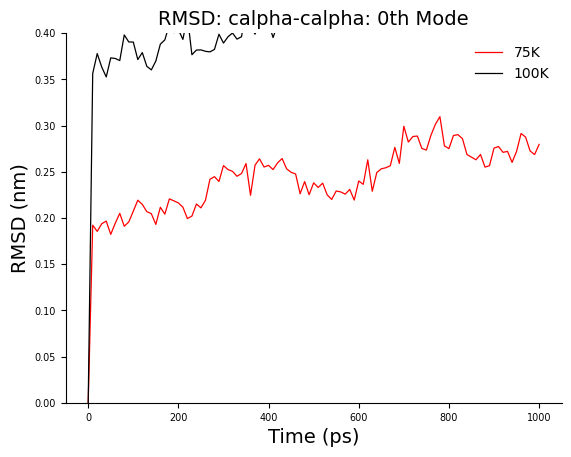

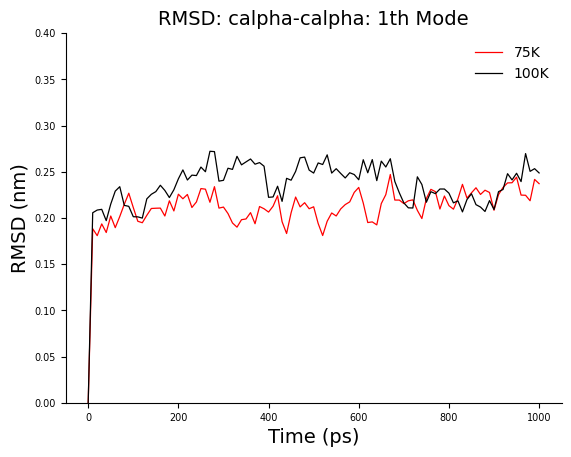

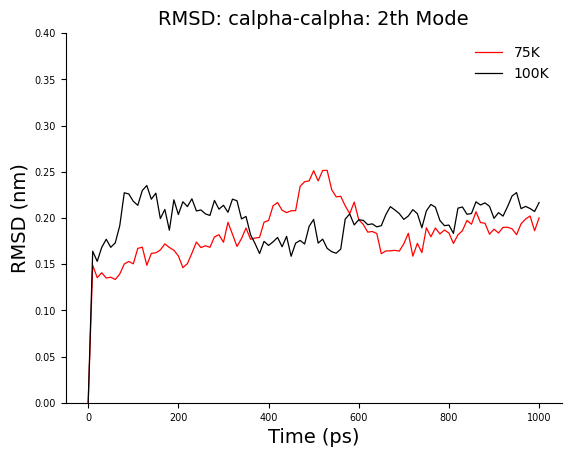

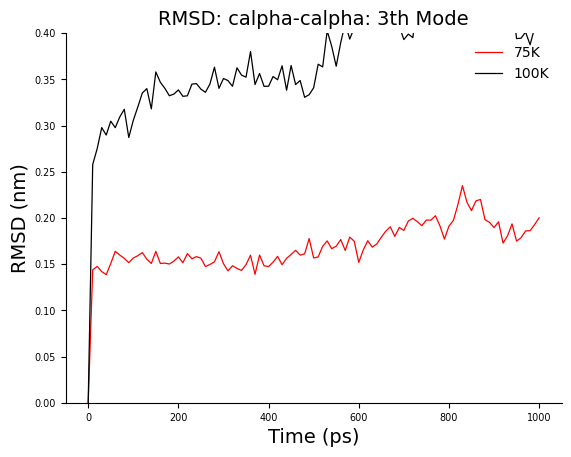

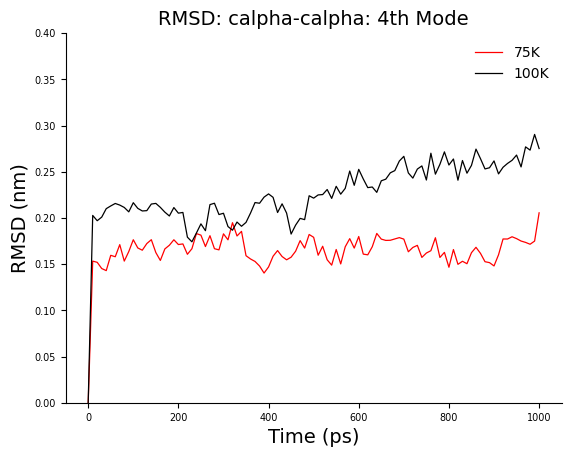

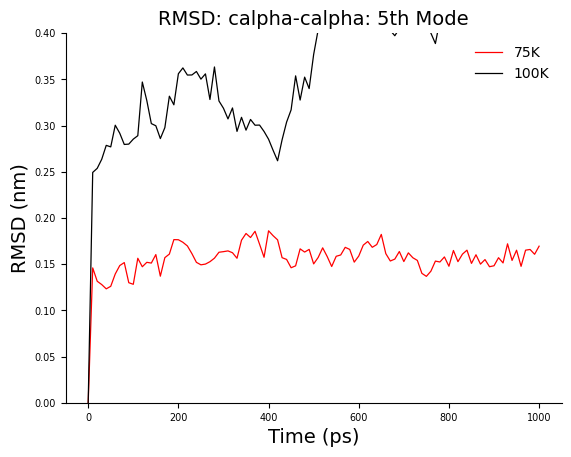

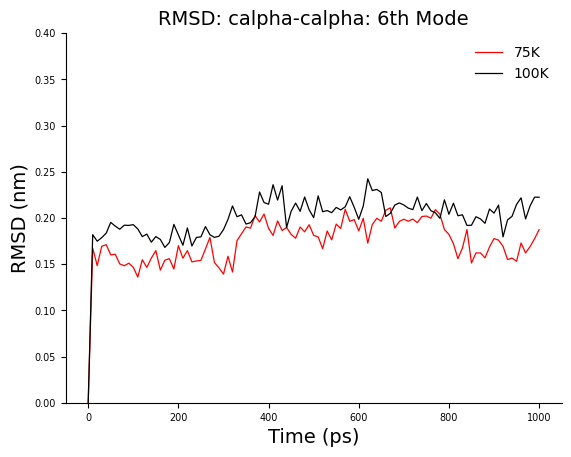

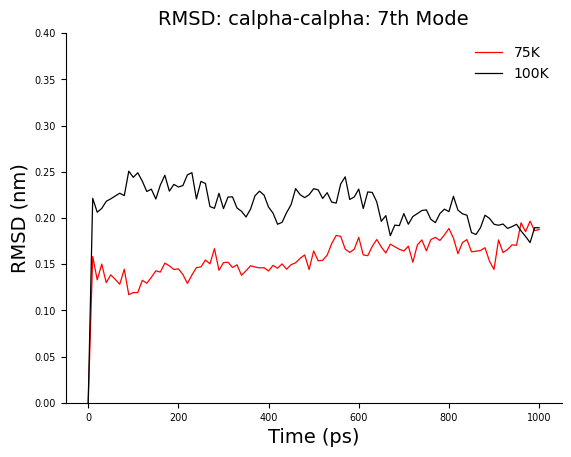

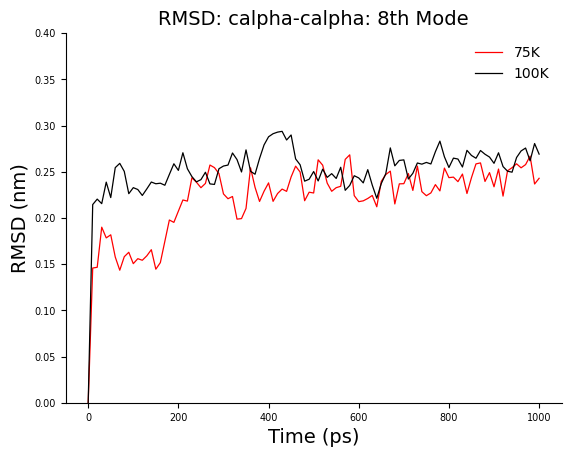

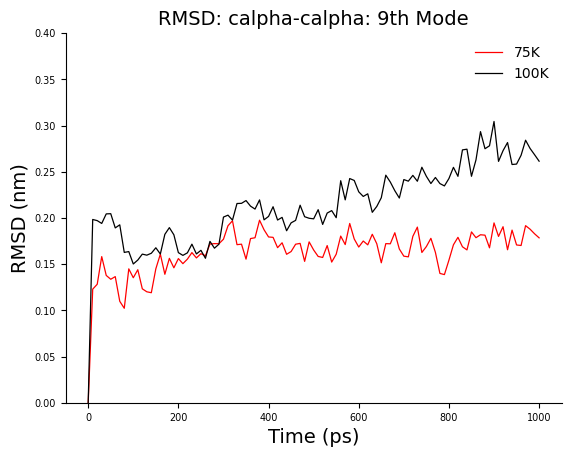

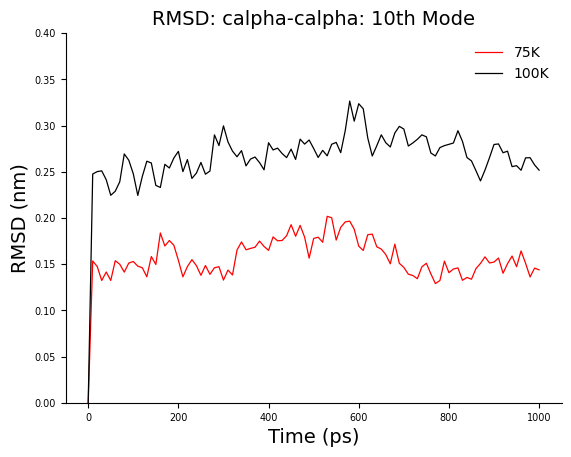

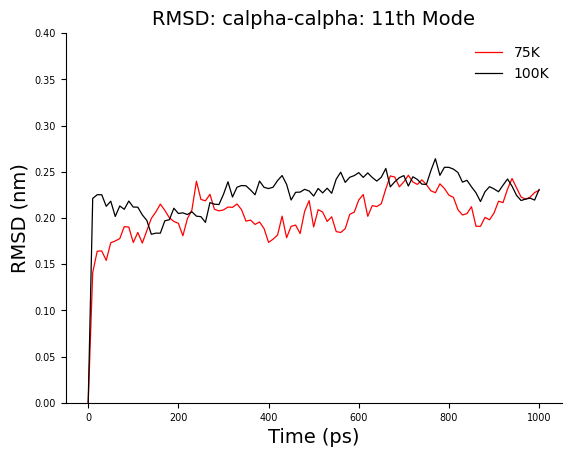

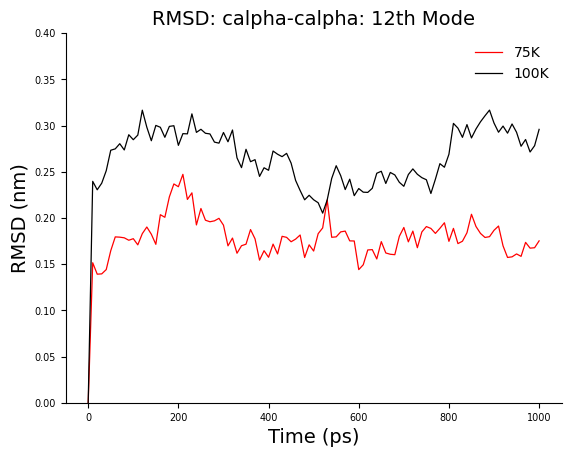

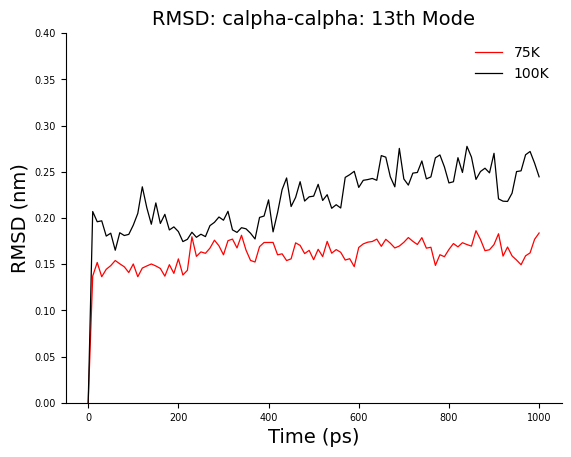

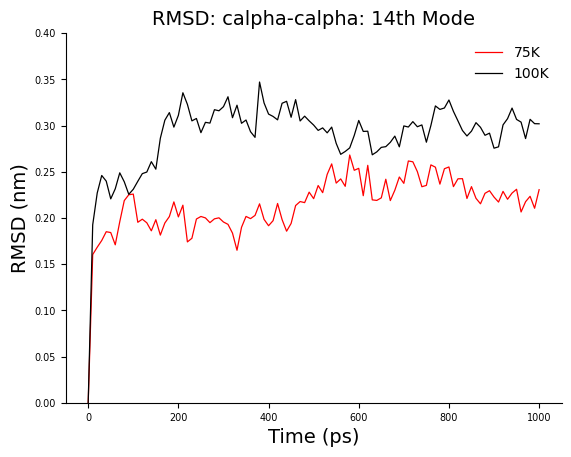

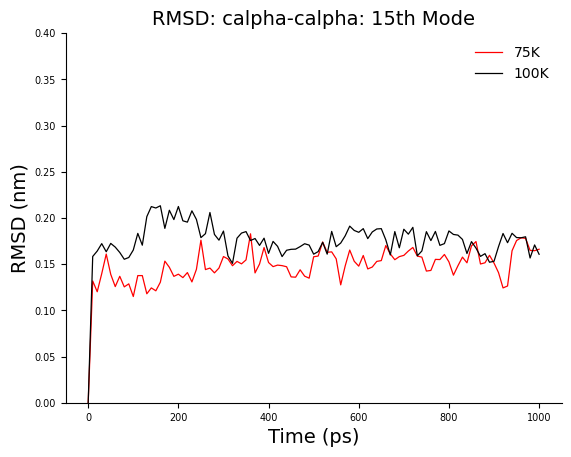

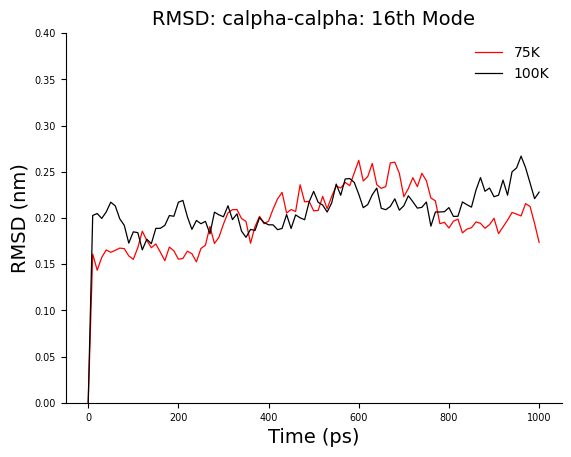

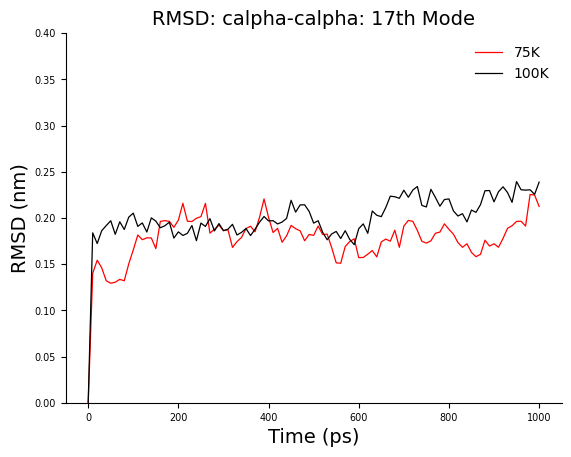

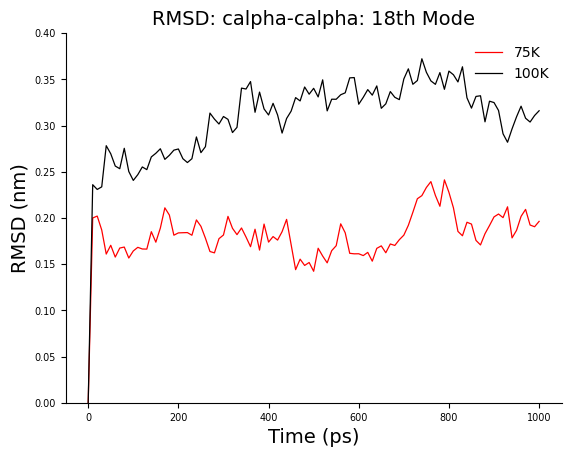

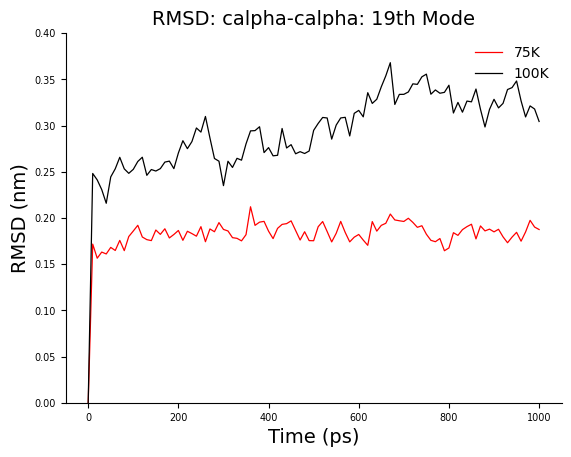

In [16]:
rmsdcc_75 = []
rmsdcc_100 = []

for i in range(20):
    filename = file_dir+"75_delT/{}_mode/rmsd_calpha_calpha.xvg".format(i)
    rmsd_75 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_75.append(rmsd_75[:, 1])
    filename = file_dir+"100_delT/{}_mode/rmsd_calpha_calpha.xvg".format(i)
    rmsd_100 = np.genfromtxt(filename, skip_header = 18)
    rmsdcc_100.append(rmsd_100[:, 1])
    plt.figure()
    ax = plt.subplot()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(rmsd_75[:, 0], rmsd_75[:, 1], label = '75K', color = 'red', linewidth = 0.9)
    ax.plot(rmsd_100[:, 0], rmsd_100[:, 1], label = '100K', color = 'black', linewidth = 0.9)
    plt.xlabel("Time (ps)", fontsize = 14)
    plt.ylabel("RMSD (nm)", fontsize = 14)
    plt.ylim(0, 0.4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("RMSD: calpha-calpha: {}th Mode".format(i), fontsize = 14)
    plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSD (nm)')

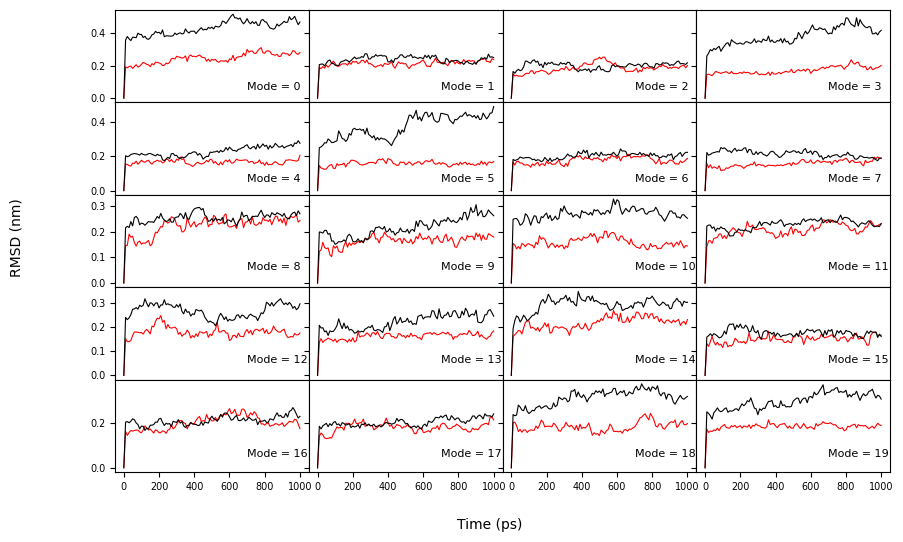

In [17]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
        axes[i, j].text(700, 0.05, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD (nm)')

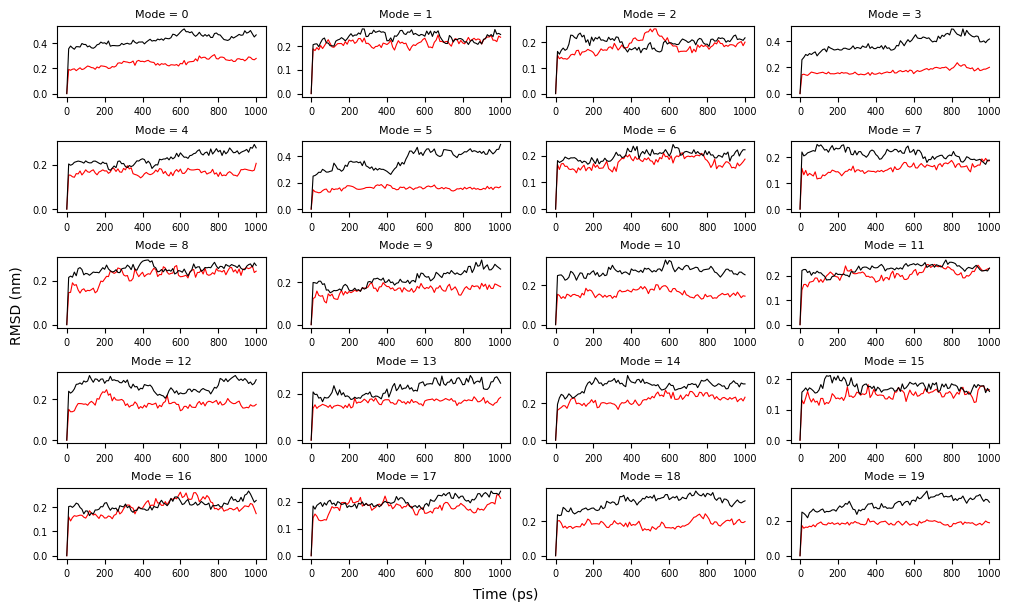

In [18]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rmsdcc_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rmsdcc_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper left", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.4)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD: calpha-calpha', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD (nm)', fontsize = 10)

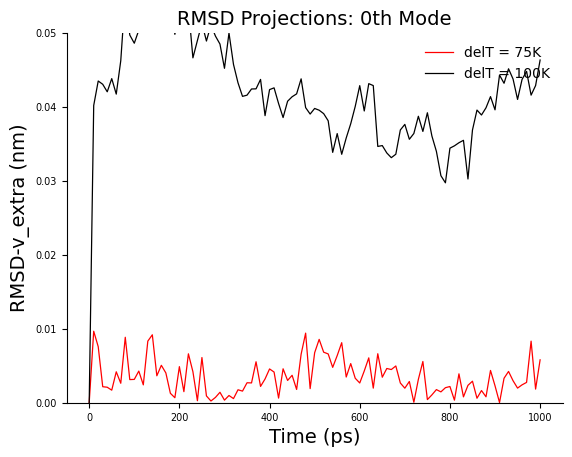

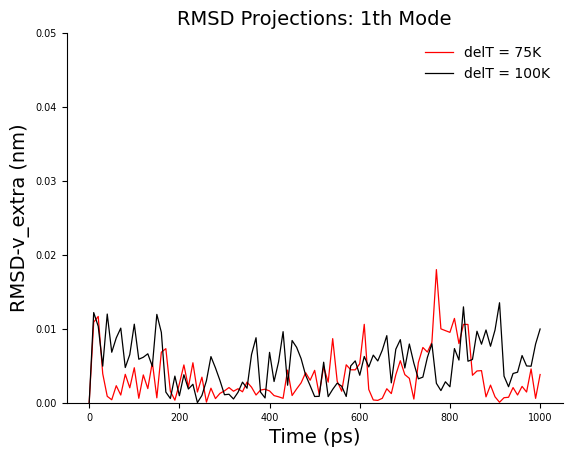

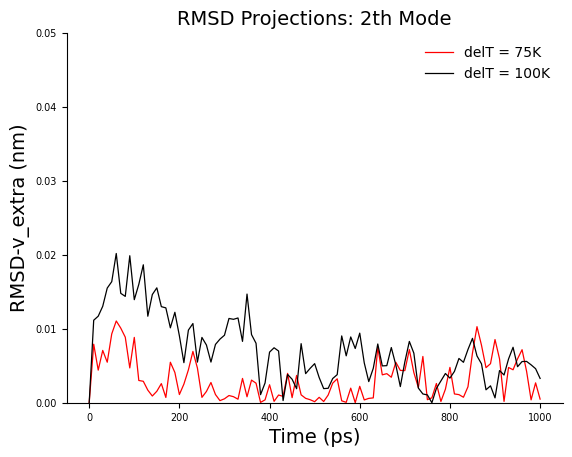

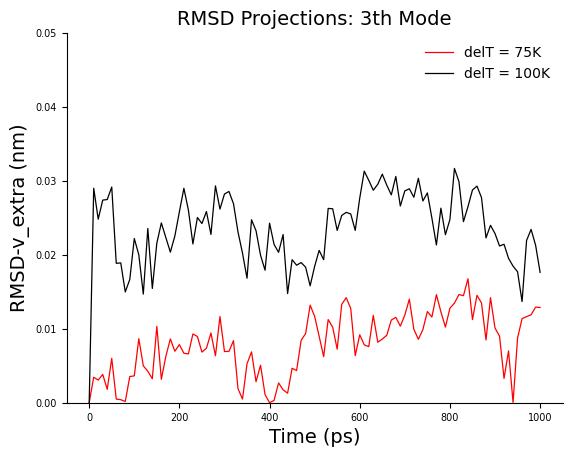

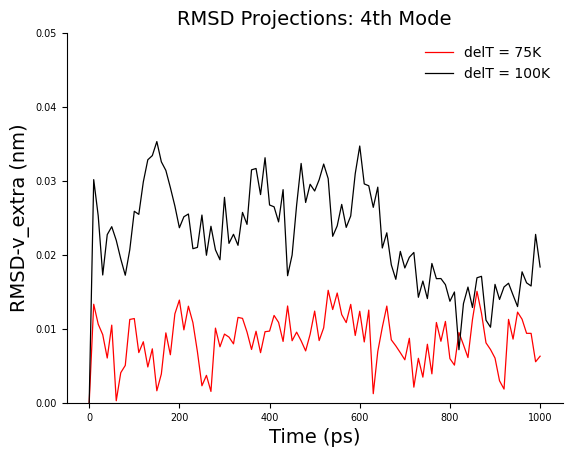

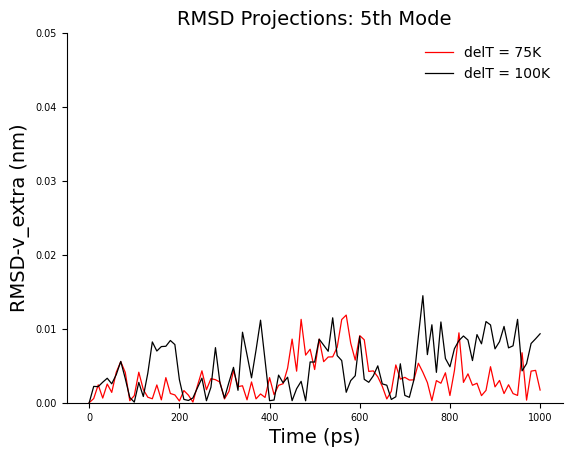

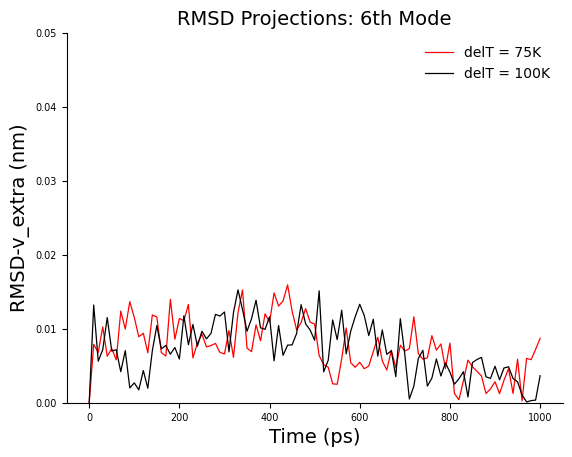

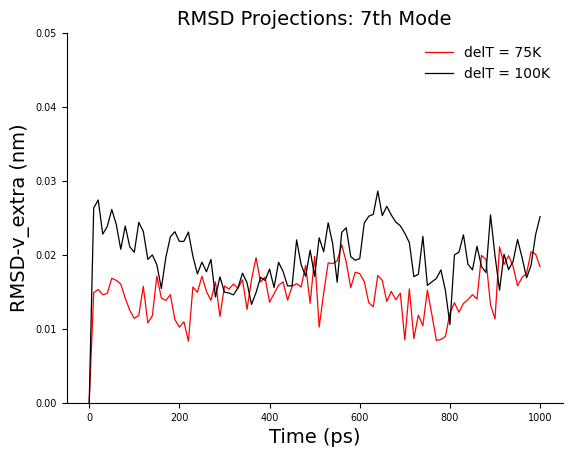

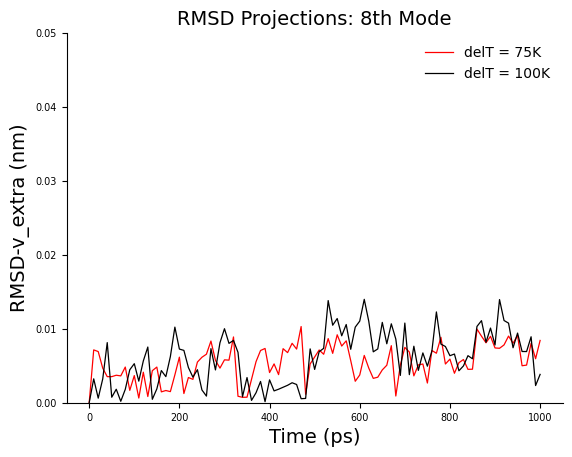

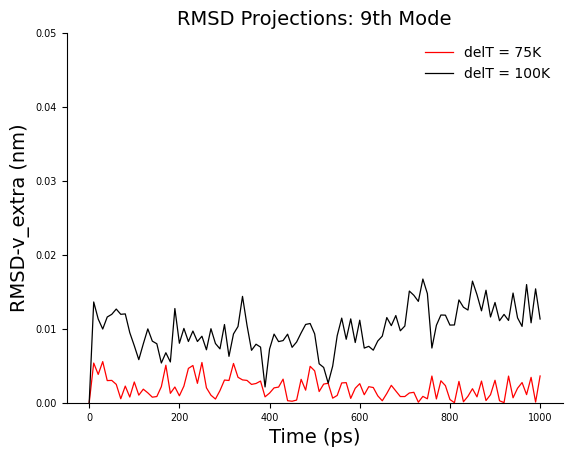

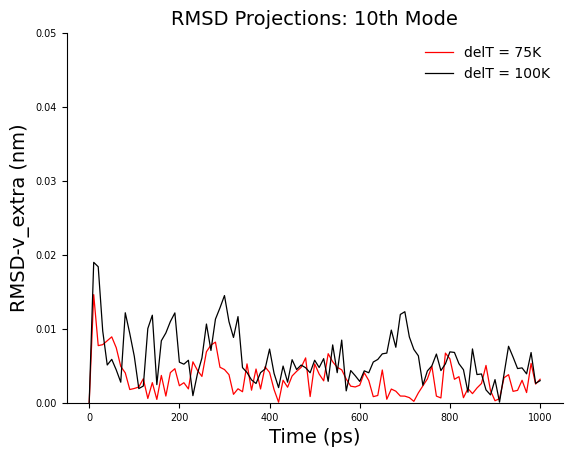

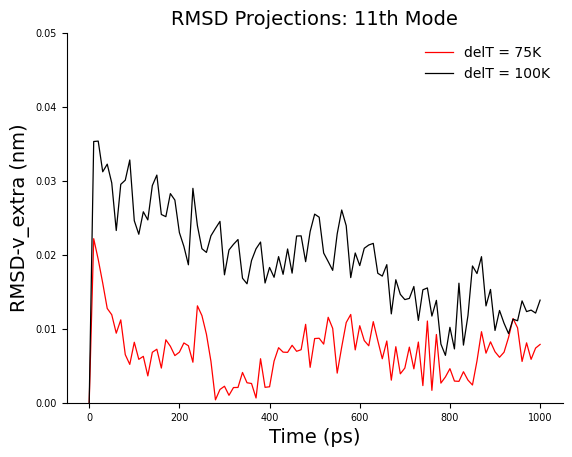

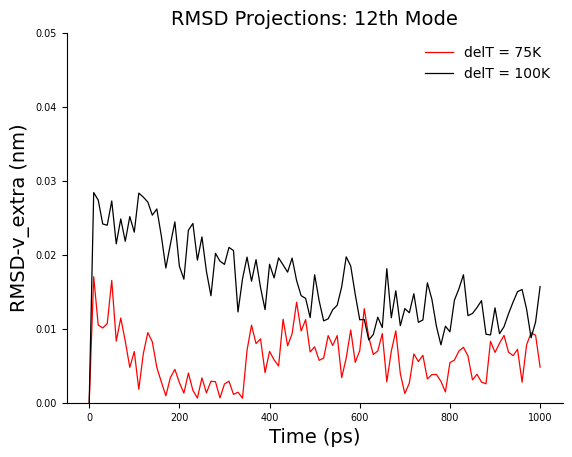

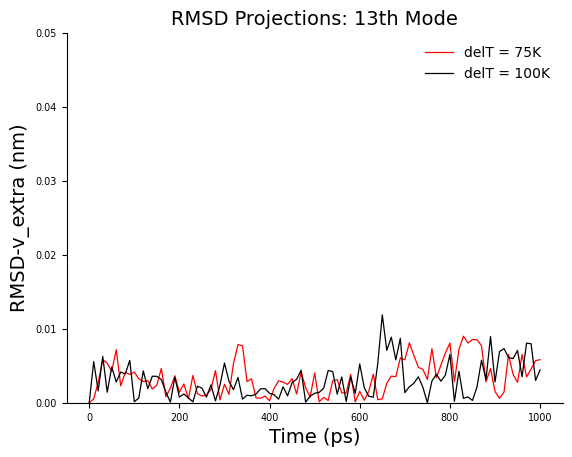

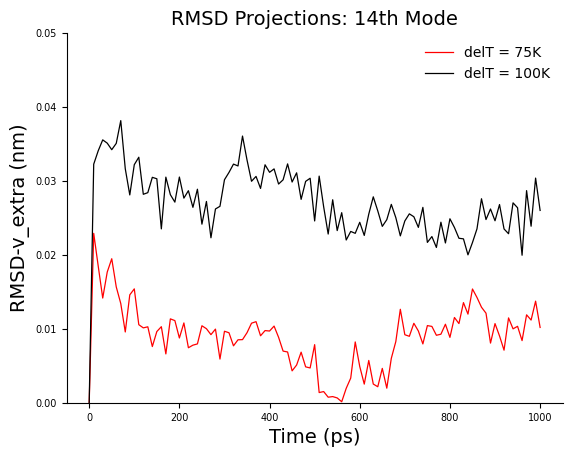

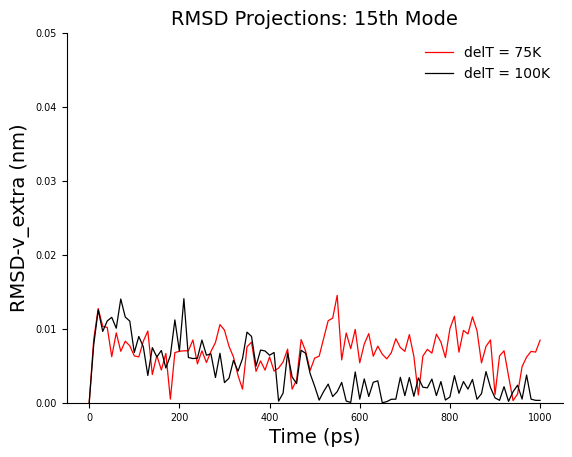

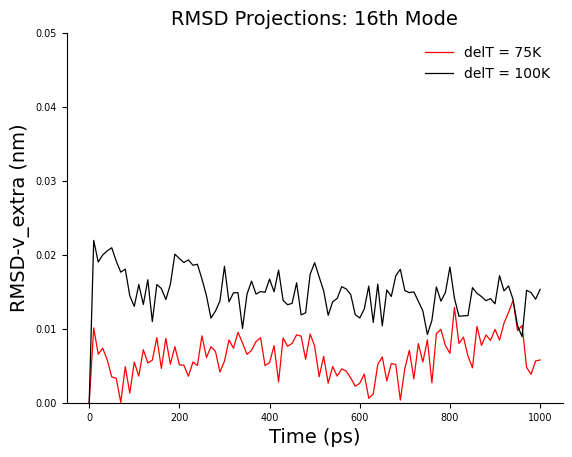

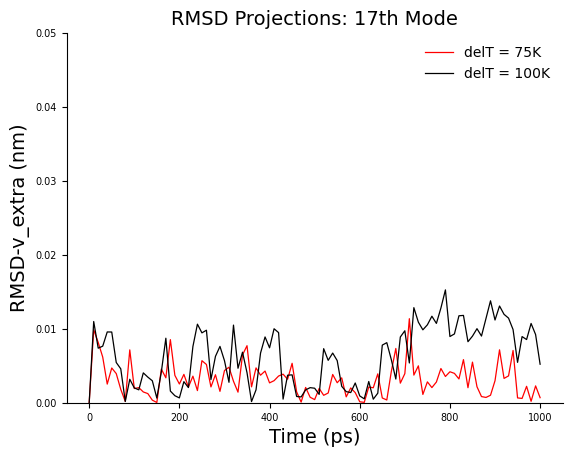

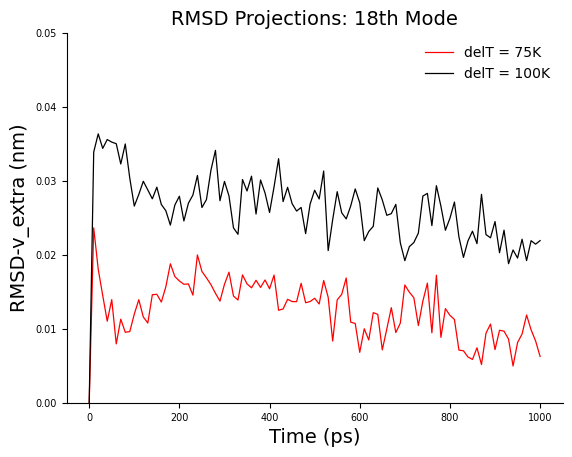

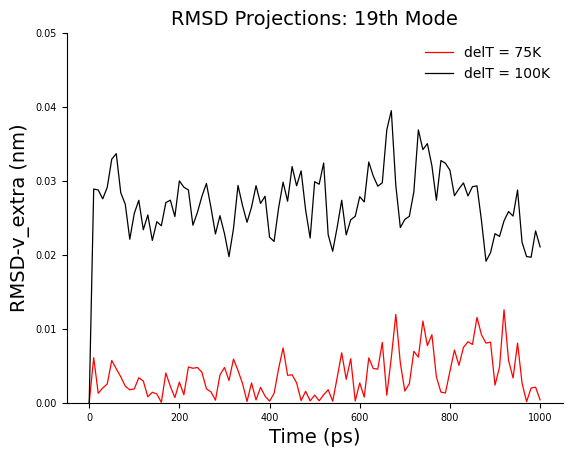

In [19]:
time = [i*10 for i in range(101)]

for i in range(20):
    fig, ax = plt.subplots()
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    ax.plot(time, rd_75[i], label = 'delT = 75K', color = 'red', linewidth = 0.9)
    ax.plot(time, rd_100[i], label = 'delT = 100K', color = 'black', linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':10})
    ax.set_xlabel('Time (ps)', fontsize = 14)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 14)
    ax.set_ylim(0, 0.05)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('RMSD Projections: {}th Mode'.format(i), fontsize = 14)
    plt.show()

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

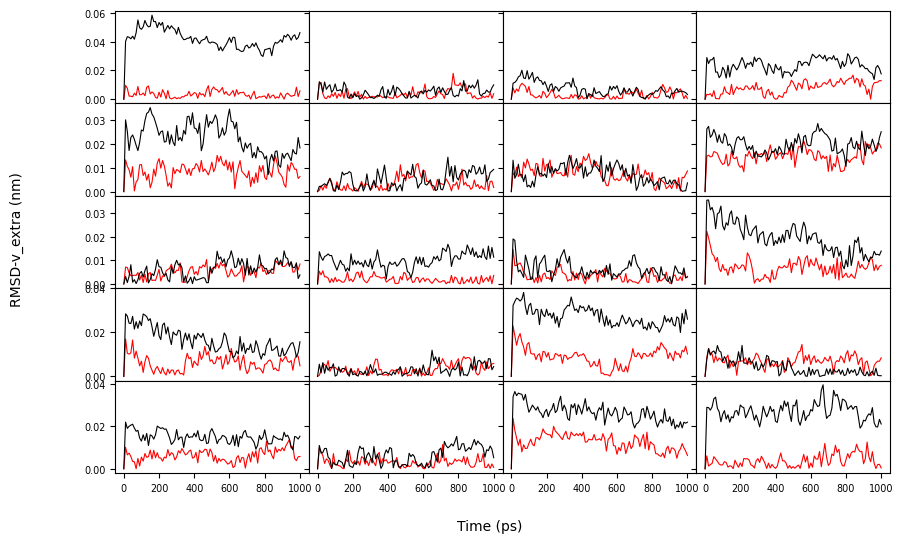

In [20]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].text(400, 0.035, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSD-v_extra (nm)')

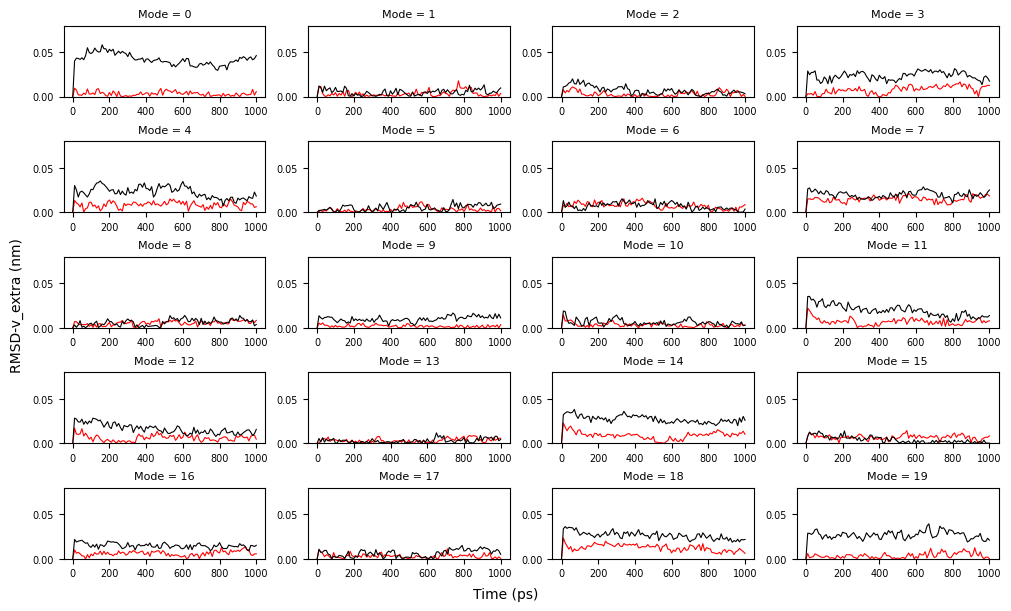

In [21]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        axes[i, j].plot(time, rd_75[j+i+lc], color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(time, rd_100[j+i+lc], color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
        axes[i, j].set_ylim(0, 0.08)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Time (ps)', fontsize = 10)
fig.supylabel('RMSD-v_extra (nm)', fontsize = 10)

Text(0.5, 1.0, 'B')

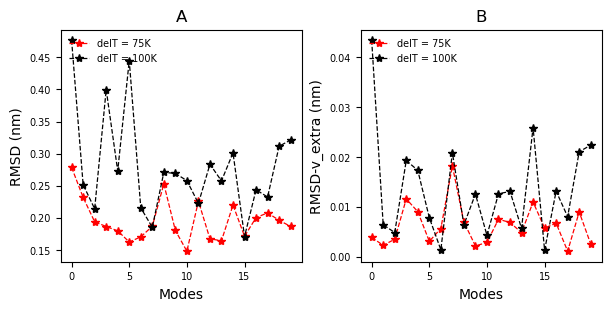

In [22]:
avg_rmsdcc_75 = []
avg_rmsdcc_100 = []
avg_rd_75 = []
avg_rd_100 = []
mode_lst = []
for k in range(20):
    avg_rmsdcc_75.append(np.average(rmsdcc_75[k][95:]))
    avg_rmsdcc_100.append(np.average(rmsdcc_100[k][95:]))
    avg_rd_75.append(np.average(rd_75[k][95:]))
    avg_rd_100.append(np.average(rd_100[k][95:]))
    mode_lst.append(k)
    

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[0].plot(mode_lst, avg_rmsdcc_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
axes[0].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[0].set_xlabel("Modes", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
axes[1].plot(mode_lst, avg_rd_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
axes[1].legend(frameon = False, loc ="upper left", prop={'size':7})
axes[1].set_xlabel("Modes", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)

    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rmsdcc_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rmsdcc_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':10})

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(mode_lst, avg_rd_75, '*', linestyle='dashed', color = 'grey', label = 'delT = 75K')
# plt.plot(mode_lst, avg_rd_100, '*', linestyle='dashed', color = 'orange', label = 'delT = 100K')
# plt.xlabel("modes", fontsize = 14)
# plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections for separate modes", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend(frameon = False, loc ="upper left", ncol = 1, prop={'size':10})

Text(0.02, 0.5, 'RMSF (nm)')

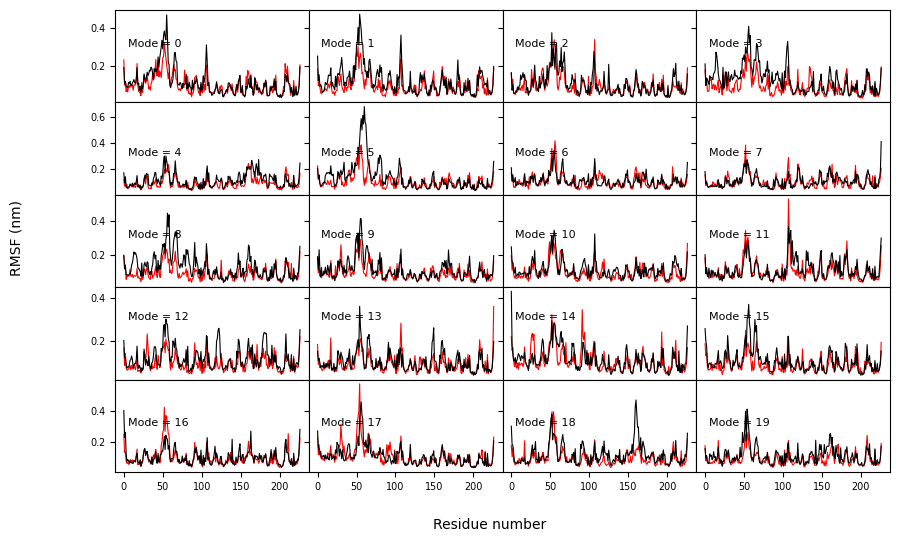

In [23]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
#fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, 4, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_100 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_100, color = 'black', label = 'delT = 100K', linewidth=0.8)
        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
#        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

Text(0.02, 0.5, 'RMSF (nm)')

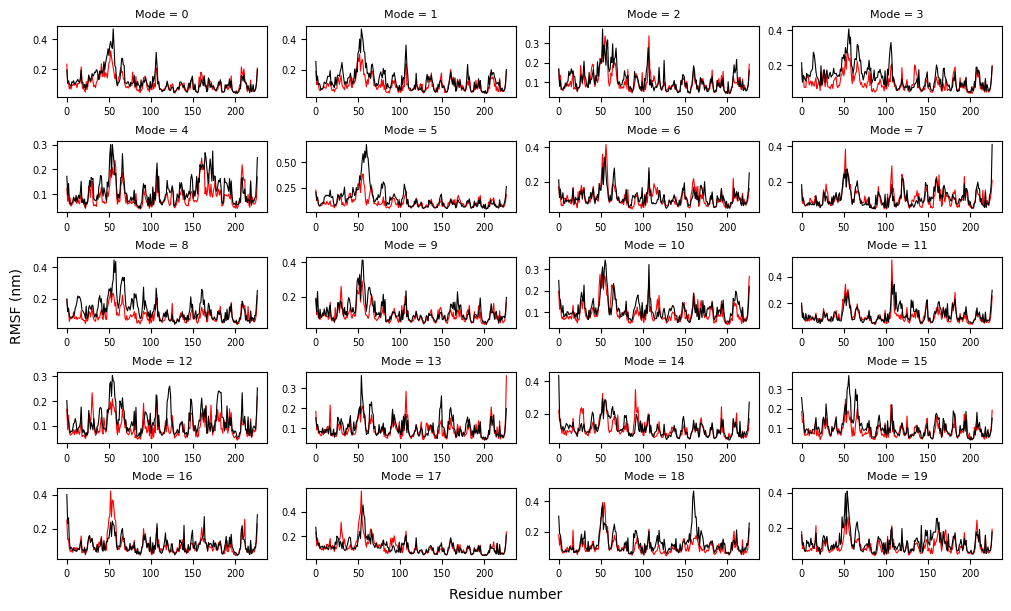

In [24]:
#fig,axes = plt.subplots(nrows=5, ncols=4, gridspec_kw={'wspace':0.5,'hspace':0.8})
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 6), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

lc = 0
for i in range(5):
    for j in range(4):
        rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_75 = np.hstack((rmsf_L, rmsf_H))
        rmsf_L = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chL.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_H = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chH.xvg".format(j+i+lc), skip_header = 17)[:, 1]
        rmsf_100 = np.hstack((rmsf_L, rmsf_H))
        axes[i, j].plot(range(227), rmsf_75, color = 'red', label = 'delT = 75K', linewidth=0.8)
        axes[i, j].plot(range(227), rmsf_100, color = 'black', label = 'delT = 100K', linewidth=0.8)
#        axes[i, j].text(5, 0.3, "Mode = {}".format(j+i+lc), fontsize = 8)
#        axes[i, j].legend(frameon = False, loc ="upper right", prop={'size':5})
#        axes[i, j].set_ylim(0, 0.05)
        axes[i, j].set_title("Mode = {}".format(j+i+lc), fontsize = 8)
    lc = lc+j
#fig.suptitle('RMSD Projections along the excitation vector', fontsize = 14)
fig.supxlabel('Residue number', fontsize = 10)
fig.supylabel('RMSF (nm)', fontsize = 10)

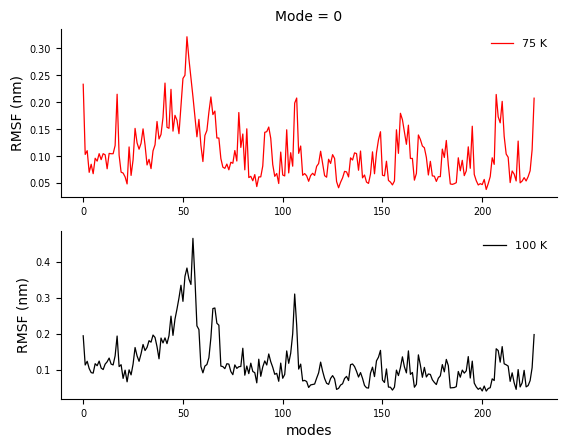

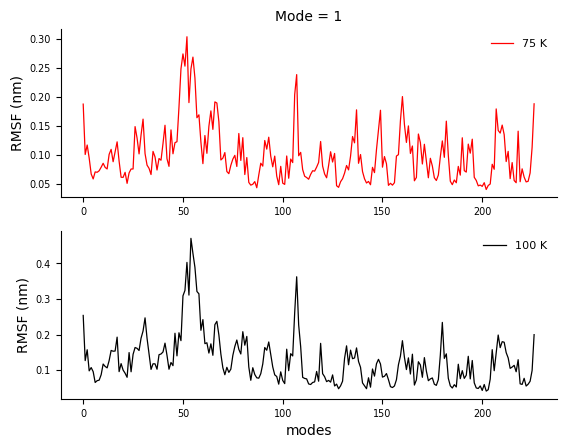

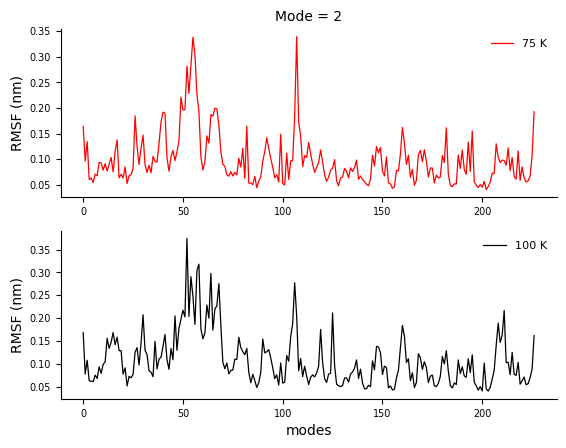

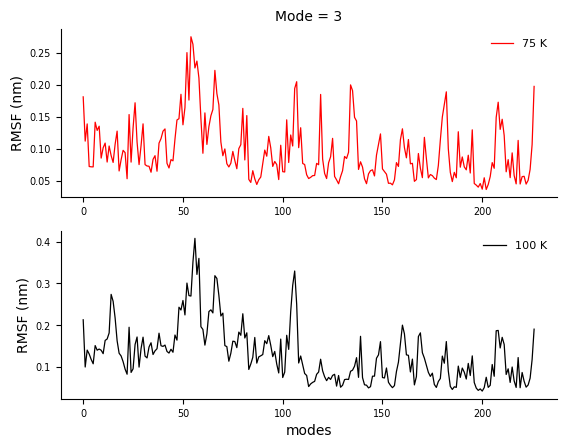

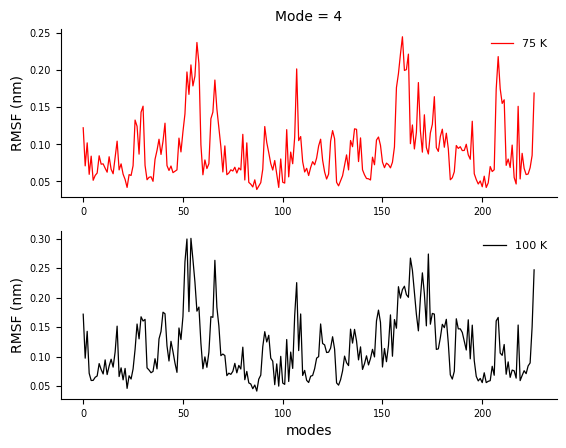

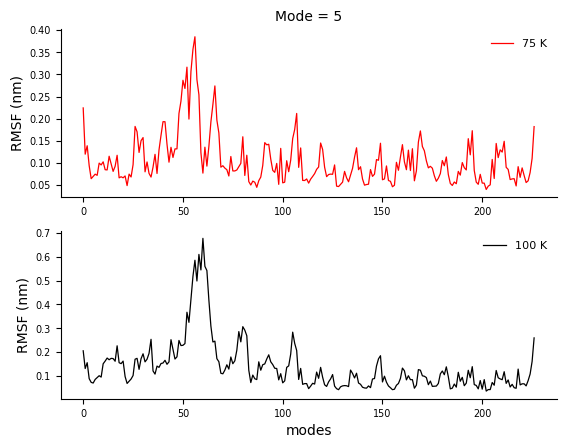

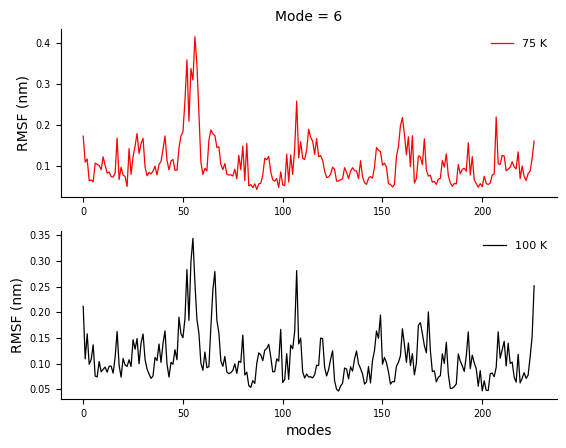

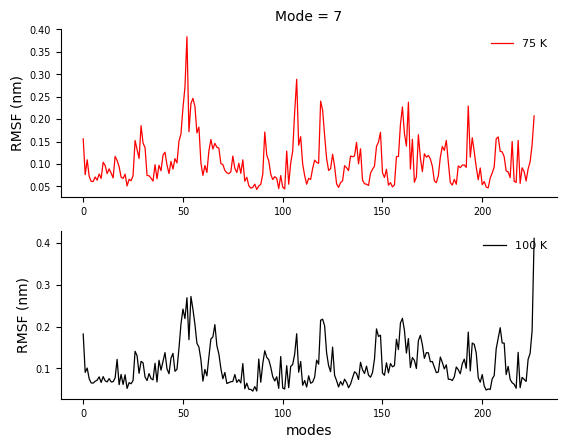

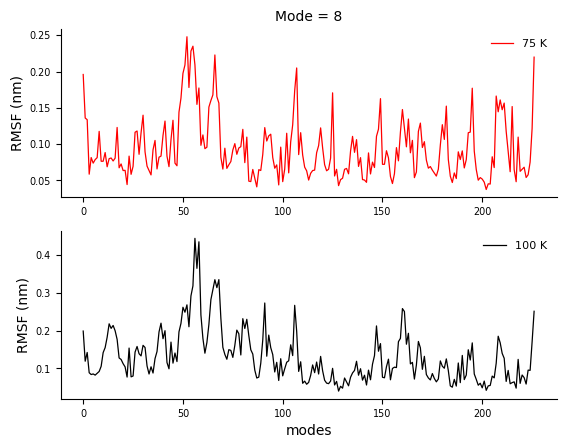

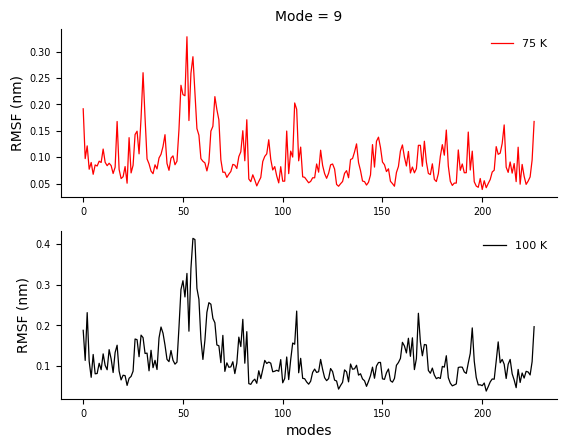

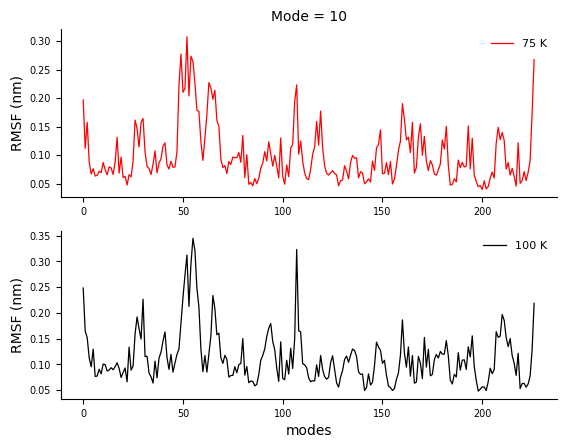

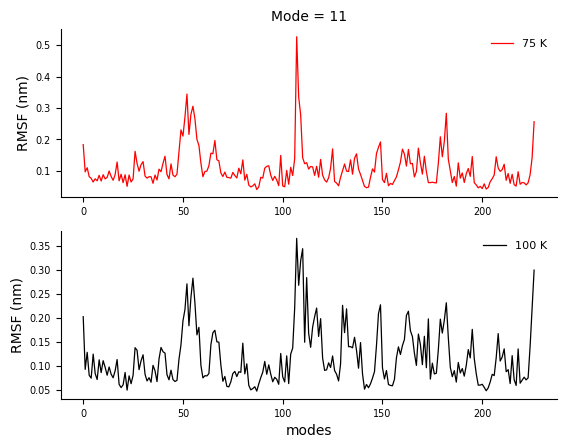

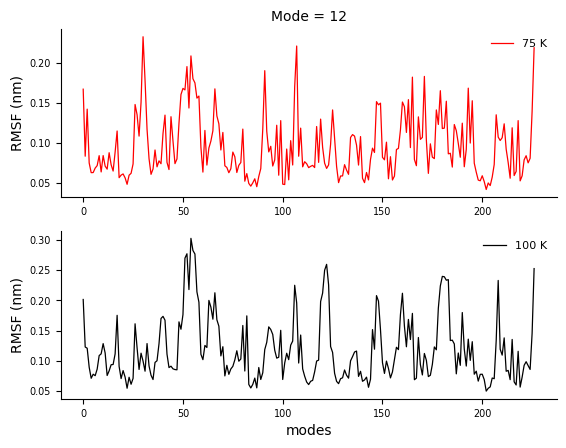

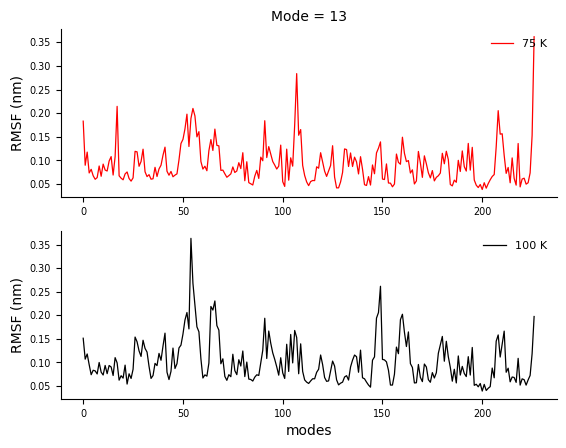

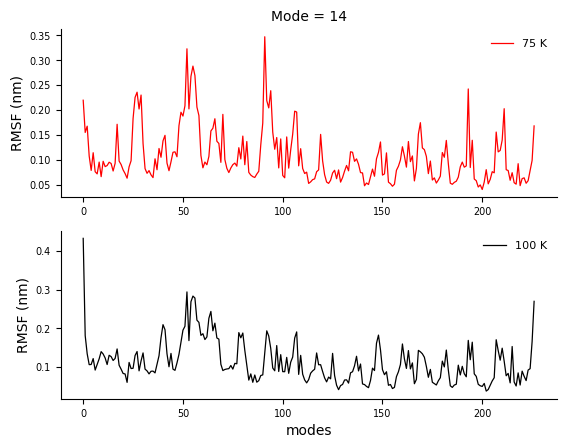

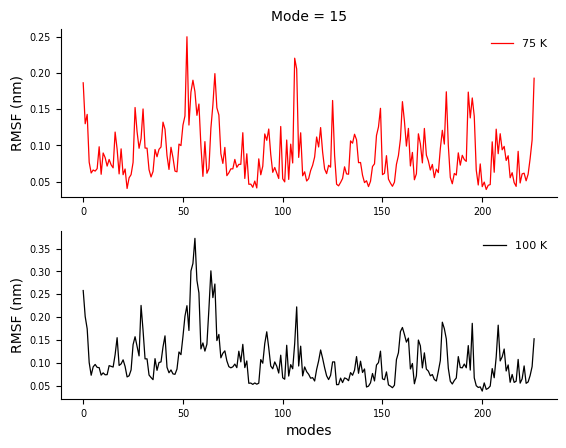

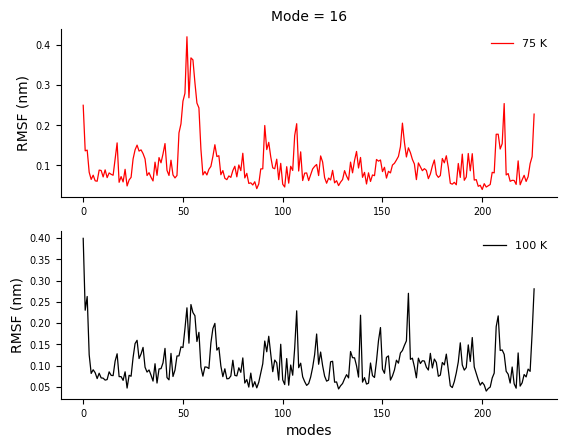

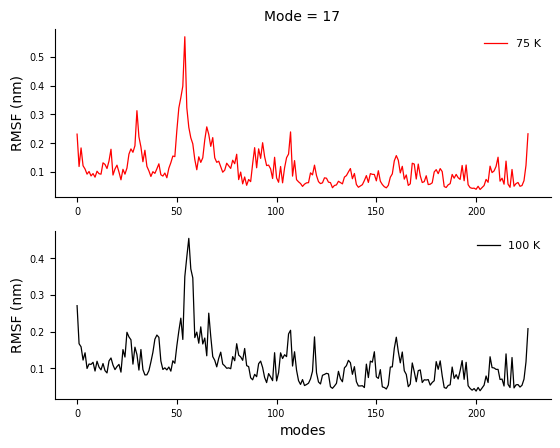

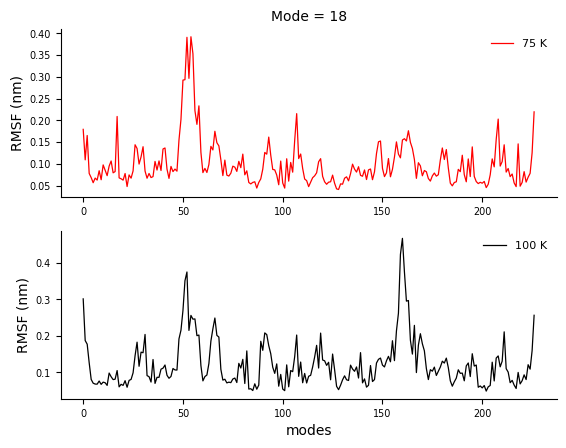

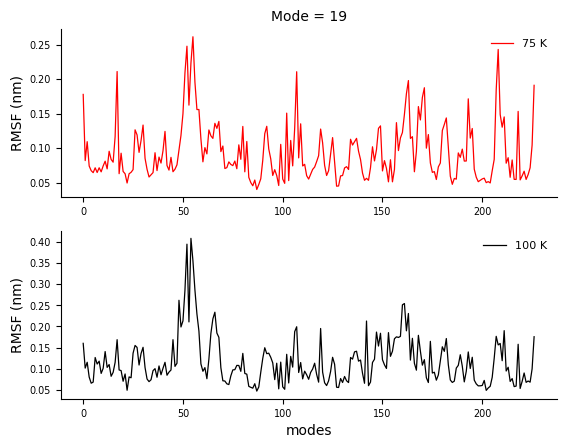

In [25]:
for i in range(20):
    rmsf_L = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chL.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt(file_dir+"75_delT/{}_mode/rmsf_chH.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_75 = np.hstack((rmsf_L, rmsf_H))
    rmsf_L = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chL.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_H = np.genfromtxt(file_dir+"100_delT/{}_mode/rmsf_chH.xvg".format(i), skip_header = 17)[:, 1]
    rmsf_100 = np.hstack((rmsf_L, rmsf_H))
    fig, axes = plt.subplots(nrows=2,ncols=1)
    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    axes[0].plot(rmsf_75, color = 'red', label = '75 K', linewidth = 0.9)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[0].set_ylabel("RMSF (nm)", fontsize = 10)
    axes[0].set_title("Mode = {}".format(i), fontsize = 10)
    axes[0].legend(frameon = False,loc ="upper right", prop={'size':8})
    axes[1].plot(rmsf_100, color = 'black', label = '100 K', linewidth = 0.9)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1].set_xlabel("modes", fontsize = 10)
    axes[1].set_ylabel("RMSF (nm)", fontsize = 10)

#### delT = 75; Finding the alpha

In [26]:
wm = v[6:26]
Um = U_m[6:26]
m = len(Um)
alpha = np.random.rand(m, 1)

In [27]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

-3.6951332618717636e-11
[0.45621092 0.07340675 0.08294789 0.15320955 0.09008514 0.02619095
 0.04658389 0.14279502 0.04970053 0.01400397 0.01630756 0.04265551
 0.03541708 0.02322319 0.04817635 0.02464805 0.0270446  0.00400837
 0.03143504 0.00875492]
1.6395766688770408e-11
[1.36865823 0.22011298 0.24885353 0.45964305 0.27030084 0.07860927
 0.13974074 0.42837583 0.1491023  0.04201637 0.04895008 0.12794215
 0.10624441 0.06966555 0.14452723 0.07393536 0.08113343 0.01201846
 0.09429296 0.02626425]
-1.901513668745025e-11
[2.28139539 0.36747668 0.41471333 0.7660777  0.45048988 0.13109457
 0.2328396  0.71391157 0.24849928 0.06998919 0.08159177 0.21319906
 0.17704978 0.11609016 0.24084772 0.12319353 0.13520893 0.02002664
 0.15713974 0.04376749]


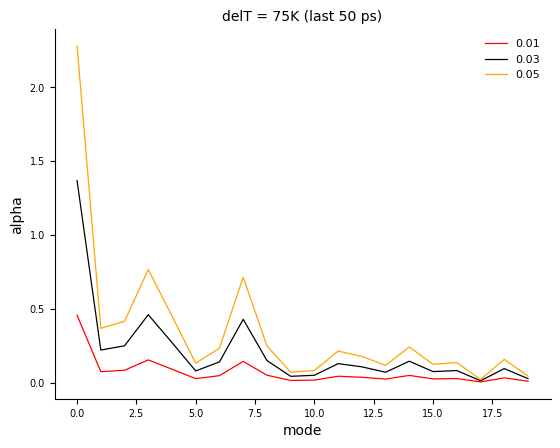

In [28]:
lst = [0.01, 0.03, 0.05]
alpha_75_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
#    alpha_m_75 = alpha_m_75/np.linalg.norm(alpha_m_75)
    alpha_75_5.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
#     plt.plot(alpha_m_75, label = str(i))
#     plt.title("delT = 75 (last 50 ps)")
#     plt.xlabel("mode")
#     plt.ylabel("alpha")
#     plt.legend(loc ="upper right", ncol = 1, prop={'size':10})
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 50 ps)", fontsize = 10)
plt.show()

In [29]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_75, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_75[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_75, m)}

1.8456845427006208e-11
[0.35772947 0.14547766 0.11519451 0.1666276  0.09350576 0.02869612
 0.03623661 0.1462459  0.05701042 0.0112719  0.01683127 0.04156144
 0.03655654 0.02878908 0.05542934 0.0333757  0.03890946 0.01195533
 0.03357373 0.02243167]
5.261978353043872e-12
[1.07490453 0.43655949 0.34542839 0.49985172 0.28035753 0.08620465
 0.10859493 0.43901409 0.17121067 0.0336358  0.05044925 0.12479737
 0.10952301 0.08622568 0.16640154 0.09973307 0.11677879 0.03552089
 0.09999604 0.06745593]
-2.0659106370057856e-11
[1.78722932 0.72862849 0.57568238 0.83344725 0.46695019 0.14375866
 0.1809228  0.73195745 0.28565686 0.05580059 0.08407003 0.20813997
 0.18254298 0.14381307 0.2772787  0.16611406 0.19459571 0.05913872
 0.16667803 0.11244162]


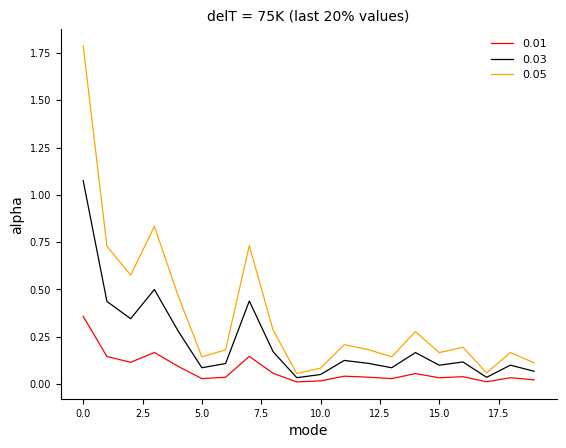

In [30]:
lst = [0.01, 0.03, 0.05]
alpha_75_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_75 = result.x
    alpha_75_20.append(alpha_m_75)
    print(constraint(alpha_m_75, rd_75, m))
    print(alpha_m_75)
    ax.plot(alpha_m_75, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 75K (last 20% values)", fontsize = 10)
plt.show()

#### delT = 100; Finding the alpha

In [31]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_100, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_100[i][95:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_100, m)}

0.011149244016653603
[0.20772548 0.00832644 0.00467594 0.01033106 0.00695773 0.00270048
 0.00044307 0.00663801 0.00184623 0.00331993 0.00097846 0.00291737
 0.00272404 0.00110369 0.00461609 0.00022703 0.00214803 0.00118758
 0.00299349 0.00311252]
0.10034310819058156
[0.62322706 0.02501125 0.01400959 0.03098981 0.02090625 0.00809869
 0.00135984 0.01988592 0.00554338 0.0099341  0.0029478  0.00871518
 0.0081865  0.00332018 0.01382539 0.00068459 0.00642271 0.00354731
 0.00896191 0.0093194 ]
0.27873086346380915
[1.03873635 0.04163854 0.02332621 0.05163117 0.03484601 0.01335031
 0.00228898 0.03317108 0.00926676 0.01652536 0.00492617 0.01455317
 0.01364293 0.00554495 0.02304533 0.00114205 0.01070237 0.00590656
 0.01493582 0.01553107]


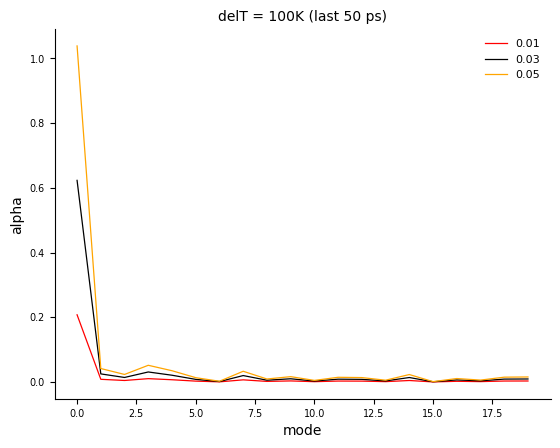

In [32]:
lst = [0.01, 0.03, 0.05]
alpha_100_5 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_100 = result.x
    alpha_100_5.append(alpha_m_100)
    print(argmin(alpha_m_100, wm))
    print(alpha_m_100)
    ax.plot(alpha_m_100, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 100K (last 50 ps)", fontsize = 10)
plt.show()

In [33]:
def argmin(alpha, wm):
    return 0.5 * np.sum(wm @ np.square(alpha))

def constraint(alpha, rd_100, m):
    summ = 0
    for i in range(m):
        summ += np.average(rd_100[i][80:])*alpha[i]
    return summ-xi

cons = {'type': 'eq', 'fun': constraint, 'args': (rd_100, m)}

0.012694176795190384
[0.21884201 0.01029745 0.00531382 0.01418757 0.00683682 0.00315803
 0.00123103 0.00710786 0.00259341 0.00387567 0.00110621 0.00326414
 0.00295249 0.00100002 0.00498623 0.00032106 0.00259843 0.00166751
 0.0035978  0.00394272]
0.11424727286592498
[0.65670416 0.03082176 0.01571341 0.04246881 0.0205819  0.00950347
 0.00369673 0.02114097 0.00768412 0.01148801 0.0033454  0.00997777
 0.00886875 0.00303132 0.01493538 0.00095057 0.00778894 0.0049916
 0.01077473 0.01182267]
0.31735382950012664
[1.09405117 0.05210012 0.02688345 0.07096421 0.03428018 0.01611877
 0.00615095 0.0352751  0.01285688 0.01911608 0.00563043 0.01659944
 0.01478256 0.00509969 0.02492548 0.00160804 0.01304923 0.00836001
 0.01799283 0.01969855]


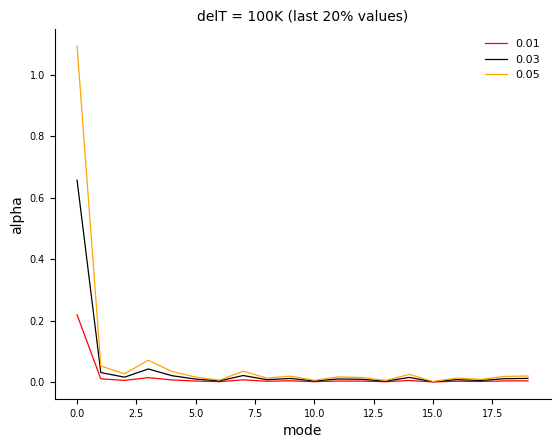

In [34]:
lst = [0.01, 0.03, 0.05]
alpha_100_20 = []
color = ['red', 'black', 'orange']
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
for i in lst:
    xi = i
    result = minimize(argmin, alpha.flatten(), args=(wm,), constraints=cons, method = 'SLSQP')
    alpha_m_100 = result.x
    alpha_100_20.append(alpha_m_100)
    print(argmin(alpha_m_100, wm))
    print(alpha_m_100)
    ax.plot(alpha_m_100, label = str(i), color = color[lst.index(i)], linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 1, prop = {'size':8})
    ax.set_xlabel('mode', fontsize = 10)
    ax.set_ylabel('alpha', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("delT = 100K (last 20% values)", fontsize = 10)
plt.show()

Text(0.02, 0.5, 'alpha')

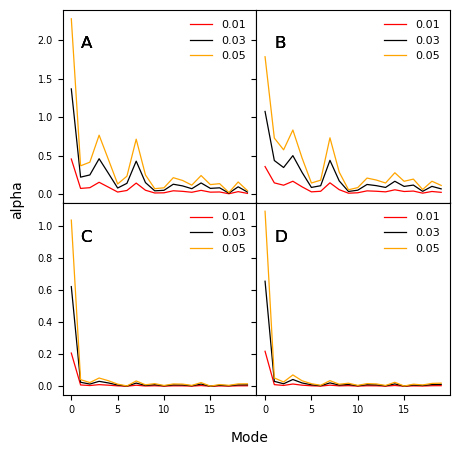

In [35]:
#fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 0].text(1, 1.9, "A", fontsize = 12)
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].text(1, 1.9, "B", fontsize = 12)
    axes[1, 0].plot(mode_lst, alpha_100_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].text(1, 0.9, "C", fontsize = 12)
    axes[1, 1].plot(mode_lst, alpha_100_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].text(1, 0.9, "D", fontsize = 12)
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

Text(0.02, 0.5, 'alpha')

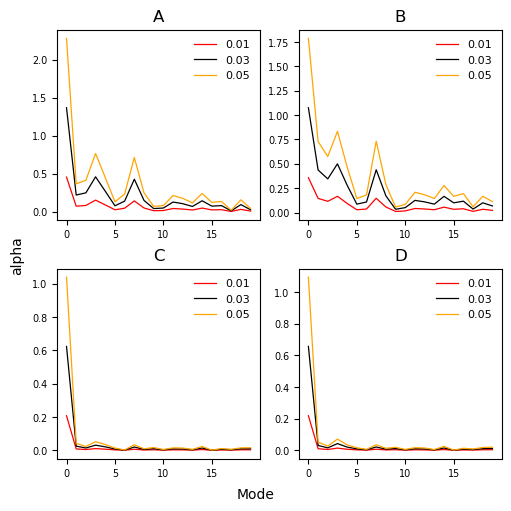

In [36]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), layout='constrained')

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for i in range(3):
    axes[0, 0].plot(mode_lst, alpha_75_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[0, 0].set_ylim(0, 1.0)
    axes[0, 0].set_title('A', fontsize = 12)
    axes[0, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[0, 1].plot(mode_lst, alpha_75_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[0, 1].set_ylim(0, 1.0)
    axes[0, 1].set_title('B', fontsize = 12)
    axes[0, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 0].plot(mode_lst, alpha_100_5[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[1, 0].set_ylim(0, 1.0)
    axes[1, 0].set_title('C', fontsize = 12)
    axes[1, 0].legend(frameon = False, loc ="upper right", prop={'size':8})
    axes[1, 1].plot(mode_lst, alpha_100_20[i], label = str(lst[i]), color = color[i], linewidth = 0.9)
#    axes[1, 1].set_ylim(0, 1.0)
    axes[1, 1].set_title('D', fontsize = 12)
    axes[1, 1].legend(frameon = False, loc ="upper right", prop={'size':8})
#fig.suptitle('Normal mode coefficients', fontsize = 14)
fig.supxlabel('Mode', fontsize = 10)
fig.supylabel('alpha', fontsize = 10)

In [37]:
d_75_5 = np.zeros((3, Um[0].shape[0]))
d_75_20 = np.zeros((3, Um[0].shape[0]))
d_100_5 = np.zeros((3, Um[0].shape[0]))
d_100_20 = np.zeros((3, Um[0].shape[0]))
for i in range(m):
    for j in range(3):
        d_75_5[j] += alpha_75_5[j][i]*Um[i]
        d_75_20[j] += alpha_75_20[j][i]*Um[i]
        d_100_5[j] += alpha_100_5[j][i]*Um[i]
        d_100_20[j] += alpha_100_20[j][i]*Um[i]
        d_75_5[j] = d_75_5[j]/np.linalg.norm(d_75_5[j])
        d_75_20[j] = d_75_20[j]/np.linalg.norm(d_75_20[j])
        d_100_5[j] = d_100_5[j]/np.linalg.norm(d_100_5[j])
        d_100_20[j] = d_100_20[j]/np.linalg.norm(d_100_20[j])

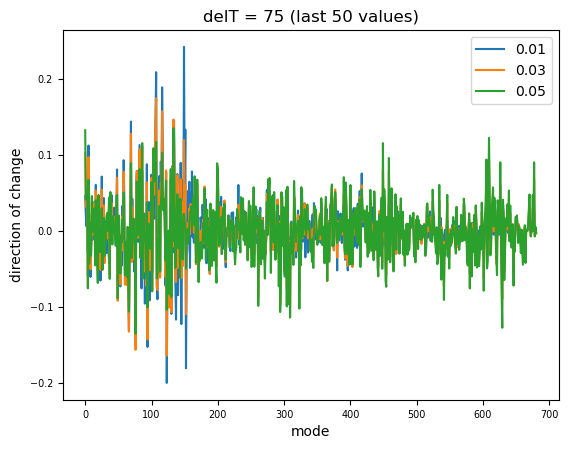

In [38]:
xi_lst = [0.01, 0.03, 0.05]
for i in range(3):
    plt.plot(d_75_5[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

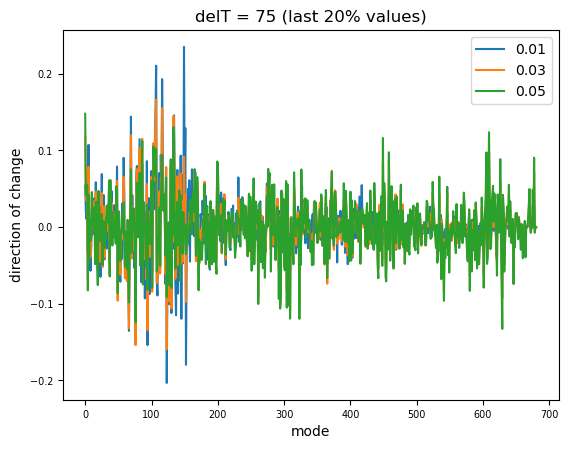

In [39]:
for i in range(3):
    plt.plot(d_75_20[i], label = str(xi_lst[i]))
    plt.title("delT = 75 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

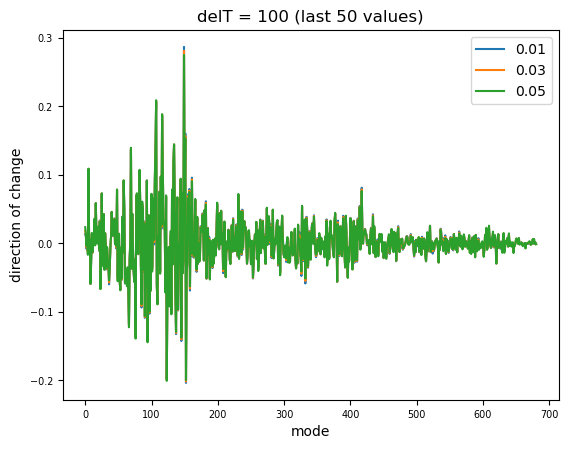

In [40]:
for i in range(3):
    plt.plot(d_100_5[i], label = str(xi_lst[i]))
    plt.title("delT = 100 (last 50 values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

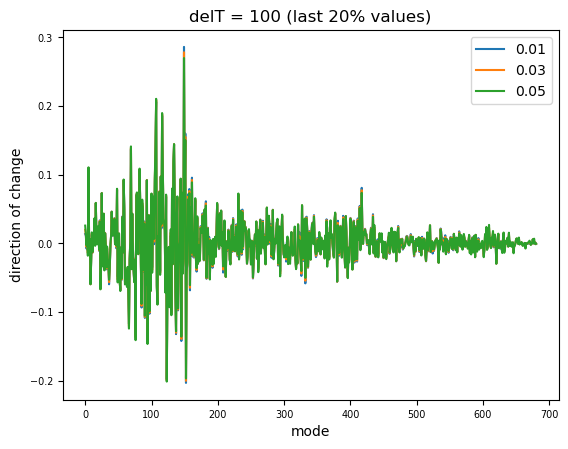

In [41]:
for i in range(3):
    plt.plot(d_100_20[i], label = str(xi_lst[i]))
    plt.title("delT = 100 (last 20% values)")
    plt.xlabel("mode")
    plt.ylabel("direction of change")
    plt.legend(loc ="upper right", ncol = 1, prop={'size':10})

In [42]:
all_d = []
for i in range(3):
    all_d.append(d_75_5[i])
for i in range(3):
    all_d.append(d_75_20[i])
for i in range(3):
    all_d.append(d_100_5[i])
for i in range(3):
    all_d.append(d_100_20[i])

In [43]:
dot_product = np.zeros((len(all_d), len(all_d)))
for i in range(len(all_d)):
    for j in range(len(all_d)):
        dot_product[i, j] = np.dot(all_d[i], all_d[j])

In [44]:
dot_product

array([[1.        , 0.87961151, 0.65297415, 0.99672501, 0.81706966,
        0.55639489, 0.96646838, 0.97492471, 0.98190024, 0.96738004,
        0.97710757, 0.9847722 ],
       [0.87961151, 1.        , 0.93025636, 0.89491253, 0.98475072,
        0.87500381, 0.72891755, 0.75274551, 0.77540539, 0.73127825,
        0.75931463, 0.78597925],
       [0.65297415, 0.93025636, 1.        , 0.67611697, 0.94718683,
        0.98323765, 0.44415656, 0.47463699, 0.50437443, 0.44698443,
        0.48273585, 0.51778658],
       [0.99672501, 0.89491253, 0.67611697, 1.        , 0.84555022,
        0.59039979, 0.95275692, 0.96324327, 0.97225545, 0.95389204,
        0.96608652, 0.97631154],
       [0.81706966, 0.98475072, 0.94718683, 0.84555022, 1.        ,
        0.92124688, 0.64605742, 0.67364995, 0.70017459, 0.64882101,
        0.68144078, 0.71299022],
       [0.55639489, 0.87500381, 0.98323765, 0.59039979, 0.92124688,
        1.        , 0.33494866, 0.3679326 , 0.40032369, 0.33803925,
        0.37685981,

## 3. Friction matrix 

In [45]:
# saving after every 0.001 seconds, simulation length = 200ps
vel = np.loadtxt(file_dir+"vel.xvg", comments=["@", "#"], unpack=True)
time = vel[0]
vel = vel[1:]

In [46]:
len(vel[0])

200001

In [47]:
vel_x = np.zeros((len(time), n_res))
vel_y = np.zeros((len(time), n_res))
vel_z = np.zeros((len(time), n_res))
for j in range(len(time)):
    vel_xx = []
    vel_yy = []
    vel_zz = []
    for i in range(0, n_res):
        vel_xx.append(vel[i*3+0][j])
        vel_yy.append(vel[i*3+1][j])
        vel_zz.append(vel[i*3+2][j])
    vel_x[j] = vel_xx
    vel_y[j] = vel_yy
    vel_z[j] = vel_zz

In [48]:
# Compute omega and initialize velocity array
n_l = n_res
m_l = n_l * 3
n = len(time)
velocity = np.zeros((m_l, n))
velocity[0:m_l:3, :] = vel_x.T
velocity[1:m_l:3, :] = vel_y.T
velocity[2:m_l:3, :] = vel_z.T

# Compute correlation function
cvv = np.zeros((11, m_l), dtype=np.float32)
for frame_diff in range(0, 11):
    velacc = np.zeros((1, m_l), dtype=np.float32)
    ind = 0
    for frame in range(199991):
        ind += 1
        velacc += np.transpose(velocity[:, frame] * velocity[:, frame + frame_diff])
    velacc /= ind
    cvv[frame_diff, :] = velacc[0]

Text(0, 0.5, 'Cvv matrix values')

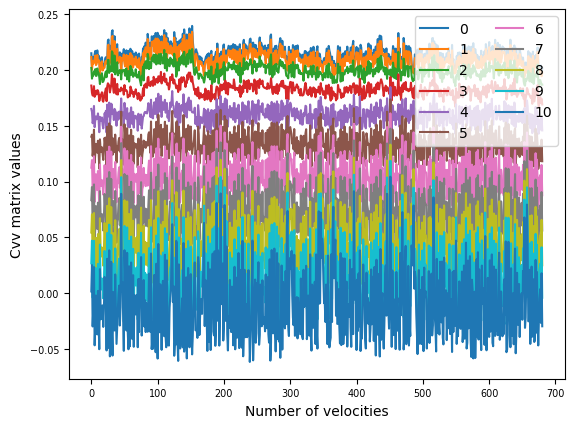

In [49]:
for i in range(11):
    plt.plot(cvv[i], label = str(i))
#plt.title("Cvv matrix")
plt.legend(loc ="upper right", ncol = 2, prop={'size':10})
plt.xlabel("Number of velocities")
plt.ylabel("Cvv matrix values")

Text(0, 0.5, 'Cvv values')

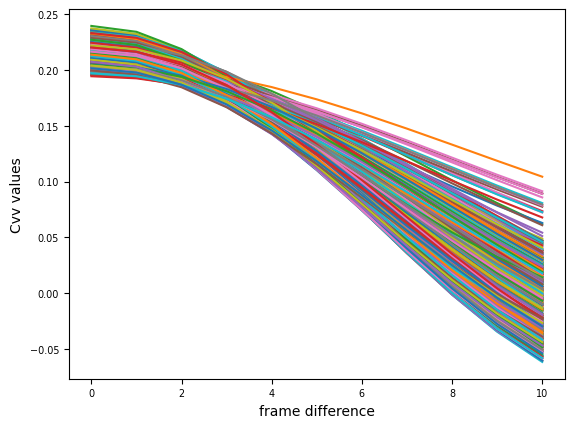

In [50]:
for i in range(681):
    plt.plot(cvv[:, i])
plt.xlabel("frame difference")
plt.ylabel("Cvv values")

In [51]:
# Compute friction and friction_NM: 0th and 5th frame each 681 entries....difference in cvv divide by time -> friction matrix (daig) element wise division
friction = cvv[4, :] - cvv[0, :]
friction = -friction/(5*0.001)
residue_mass = CA.residues.masses/1000
residue_mass = np.repeat(residue_mass, 3)
for i in range(681):
    friction[i] = friction[i]/residue_mass[i]
friction = friction/(8.3144*310*0.001) # ps-1
friction = np.diag(friction)
print(friction)
friction_NM = []
for i in range(20):
    friction_NM.append(Um[i].T @ friction @ Um[i])
print(friction_NM)

[[33.353817  0.        0.       ...  0.        0.        0.      ]
 [ 0.       27.072779  0.       ...  0.        0.        0.      ]
 [ 0.        0.       39.788578 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ... 43.26711   0.        0.      ]
 [ 0.        0.        0.       ...  0.       29.673922  0.      ]
 [ 0.        0.        0.       ...  0.        0.       41.927616]]
[44.97924833971874, 40.96828969105944, 43.50351479248688, 44.19411432932095, 41.70281069819767, 43.025436906253056, 41.861725058744064, 41.16905257691769, 42.65944227122932, 40.23801853428325, 40.00660090058784, 41.84725216669377, 41.433447279798614, 40.55269072978933, 43.63673121457309, 42.22925032451596, 42.93053814207401, 44.191411676965146, 41.36598613845304, 41.96850838304921]


## 4. Estimating beta_m 

[48.39065755 18.05373098 15.23832668 22.85443544 12.36793851  3.96807565
  4.89218934 19.59032349  7.96758401  1.50695105  2.2938789   5.89828663
  5.22027879  4.0888045   8.52562936  5.00471902  6.01673752  1.91583372
  5.18180828  3.55323318]


Text(0.5, 1.0, 'delT = 75 K')

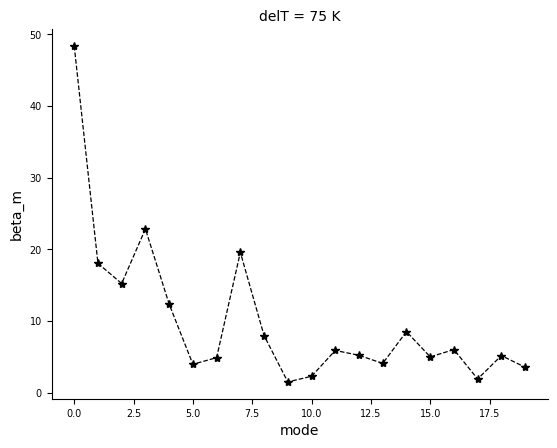

In [52]:
#for delT = 75
a = np.zeros(m)
b = np.zeros(m)
beta_m_75 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_75[i] = alpha_75_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_75)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_75, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

[29.56387788  1.27462059  0.69318582  1.9417773   0.90796812  0.43745305
  0.16653724  0.94338281  0.3575937   0.51468596  0.15211192  0.4715785
  0.42271818  0.14374448  0.76521823  0.04770053  0.40130595  0.26922405
  0.55834771  0.62275798]


Text(0.5, 1.0, 'delT = 100 K')

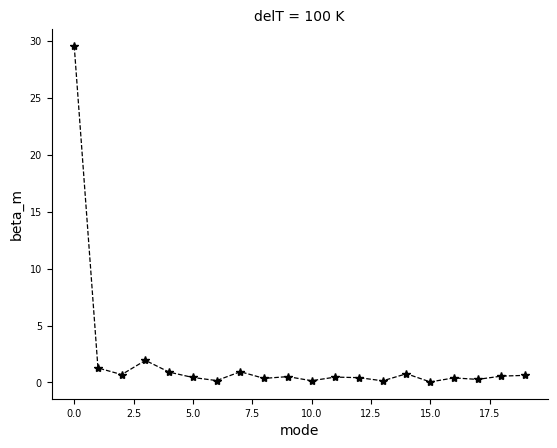

In [53]:
#for delT = 100
a = np.zeros(m)
b = np.zeros(m)
beta_m_100 = np.zeros(m)
for i in range(m):
    a[i] = 0.5 * (-friction_NM[i] + np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    b[i] = 0.5 * (-friction_NM[i] - np.sqrt(np.abs(friction_NM[i]**2 - 4*wm[i]**2)))
    beta_m_100[i] = alpha_100_20[1][i] * (a[i]-b[i]) / ((np.abs(a[i]/b[i])**(a[i]/(b[i]-a[i])) - np.abs(a[i]/b[i])**(b[i]/(b[i]-a[i]))))
print(beta_m_100)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(beta_m_100, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
ax.set_xlabel('mode', fontsize = 10)
ax.set_ylabel('beta_m', fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 100 K", fontsize = 10)

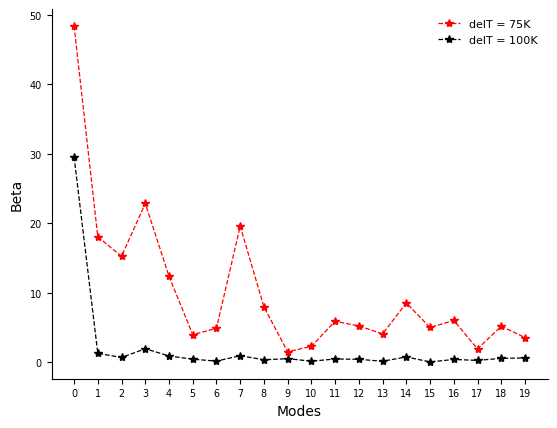

In [54]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(mode_lst, beta_m_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(mode_lst, beta_m_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
plt.xlabel("Modes", fontsize = 10)
plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("Beta", fontsize = 10)
#plt.title("Average RMSD for separate modes", fontsize = 14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="upper right", ncol = 1, prop={'size':8})

## 5. Degree of excitation 

In [55]:
# for delT = 75
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_75[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

Text(0.5, 1.0, 'delT = 75 K')

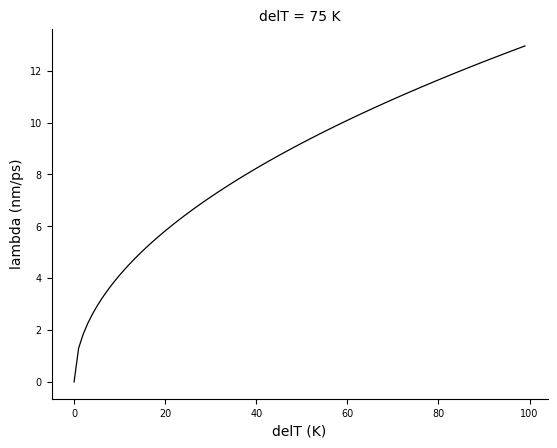

In [60]:
delT = range(0, 100)
lam_75 = []
for k in delT:
    lam_75.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_75, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 75 K", fontsize = 10)

In [ ]:
# for delT = 100
v_extra = np.zeros(Um[0].shape)
for i in range(m):
    v_extra += beta_m_100[i]*Um[i]
#    v_extra = v_extra/np.linalg.norm(v_extra)
M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

v_excite = np.zeros(antibody.n_atoms*3)
for i in range(antibody.n_residues):
    for j in antibody.residues[i].atoms.indices:
        v_excite[3*j] = v_extra[3*i]
        v_excite[3*j+1] = v_extra[3*i+1]
        v_excite[3*j+2] =  v_extra[3*i+2]
u = mda.Universe(box,box)
alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2) #lambda in nm/ps
#lmda = (alpha* 75)**0.5

Text(0.5, 1.0, 'delT = 100 K')

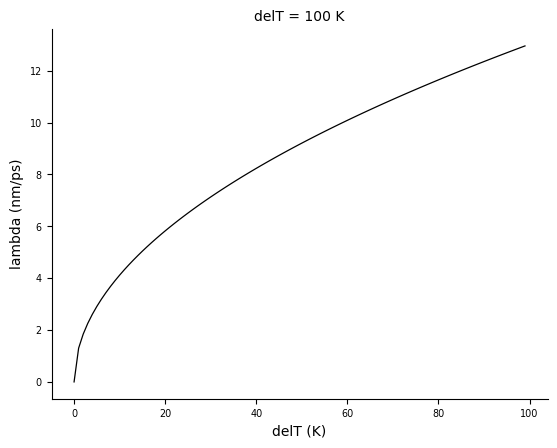

In [61]:
delT = range(0, 100)
lam_100 = []
for k in delT:
    lam_100.append((alpha*k)**0.5)
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.plot(delT, lam_100, color = 'black', linewidth = 0.9)
ax.set_xlabel("delT (K)", fontsize = 10)
ax.set_ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("delT = 100 K", fontsize = 10)

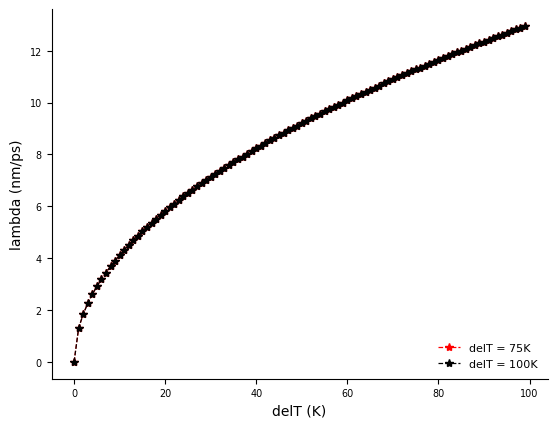

In [62]:
fig, ax = plt.subplots()
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.plot(delT, lam_75, '*', linestyle='dashed', color = 'red', label = 'delT = 75K', linewidth = 0.9)
plt.plot(delT, lam_100, '*', linestyle='dashed', color = 'black', label = 'delT = 100K', linewidth = 0.9)
plt.xlabel("delT (K)", fontsize = 10)
#plt.xticks(np.arange(min(mode_lst), max(mode_lst)+1, 1))
plt.ylabel("lambda (nm/ps)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon = False, loc ="lower right", ncol = 1, prop={'size':8})

### Excitation along normal modes

In [63]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_75[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra.reshape(-1,3)

In [64]:
def save_gro(Um, v_extra, gro_in, delT):
    gro = mda.Universe(gro_in)
    frame = gro.trajectory[-1]
    for i in range(antibody.n_residues):
        for j in gro.residues[i].atoms.indices:
            frame.velocities[j] += v_extra[i]
    filename = file_dir+'withlambda_{}_delT/md.gro'.format(delT)
    print(f"Writing new GRO file to {filename}")
    gro.atoms.write(filename, reindex=False)

In [65]:
gro_in = file_dir+"confout_1.gro"
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130, 140, 150]
for k in delT:
    v_extra = excite(Um, box, k)
    save_gro(Um, v_extra, gro_in, k)

Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_10_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_20_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_30_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_40_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_50_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/withlambda_70_delT/withlambda_60_delT/md.gro
Writing new GRO file to /scratch/chemical/dual/ch7180271/MTP_Work/RMSD/RMSD_inc_temp/withlambda_70_delT/wi

## New structures (excitation alogn direction of min energy)

In [66]:
box = file_dir+"box.pdb"
pdb = file_dir+"pdb_ref.pdb"
x = mda.Universe(pdb, pdb)
antibody = x.select_atoms('chainID A or chainID B')

def excite(Um, box, delT):
    v_extra = np.zeros(Um[0].shape)
    for i in range(m):
        v_extra += beta_m_75[i]*Um[i]
    v_extra = v_extra/ np.linalg.norm(v_extra)
    
    M_exite = np.zeros((antibody.n_atoms*3, antibody.n_atoms*3))
    np.fill_diagonal(M_exite,(antibody.masses.repeat(3)/1000) ** 0.5)

    v_excite = np.zeros(antibody.n_atoms*3)
    for i in range(antibody.n_residues):
        for j in antibody.residues[i].atoms.indices:
            v_excite[3*j] = v_extra[3*i]
            v_excite[3*j+1] = v_extra[3*i+1]
            v_excite[3*j+2] =  v_extra[3*i+2]
    u = mda.Universe(box,box)
    alpha = (3 * u.atoms.n_atoms * 0.008314) / (np.linalg.norm(M_exite @ v_excite)**2)
    lmda = (alpha * delT)**0.5
    v_extra = 0.316 *lmda * v_extra # Convert to Angs/ps
    return v_extra

def residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, selection, Um, delT):
    u = mda.Universe(pdb_mdenm, xtc_mdenm)
    v = mda.Universe(pdb_ref, pdb_ref)
    v_lrt = excite(Um, box, delT)
    v_lrt = v_lrt/np.linalg.norm(v_lrt) 
    u_fvca = u.select_atoms(selection)
    v_fvca = v.select_atoms(selection)
    dp = []
    for _ in u.trajectory:
        _ = align.alignto(u_fvca, v_fvca)
        deformation = (u_fvca.positions - v_fvca.positions).flatten()
        dp.append((np.dot(deformation, v_lrt)**2/u_fvca.n_residues)**0.5)
    return np.array(dp)

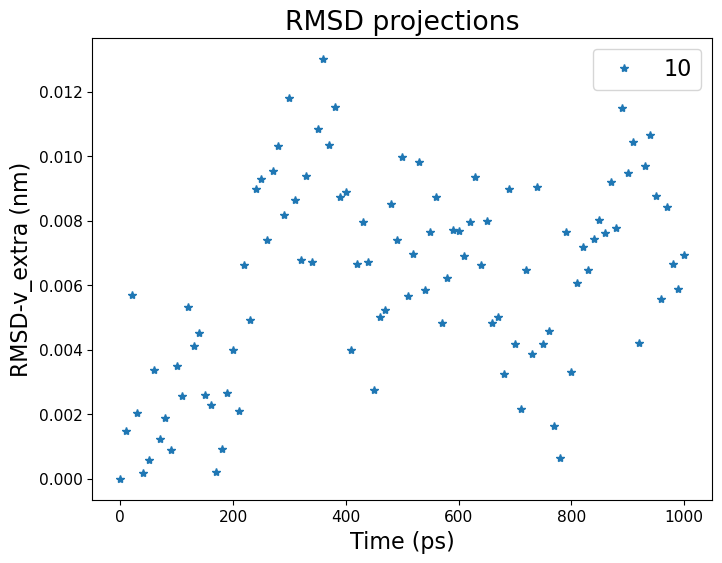

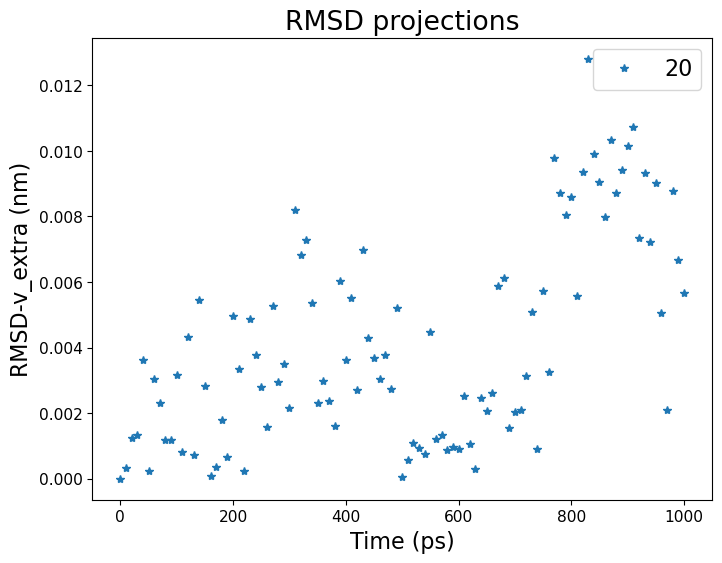

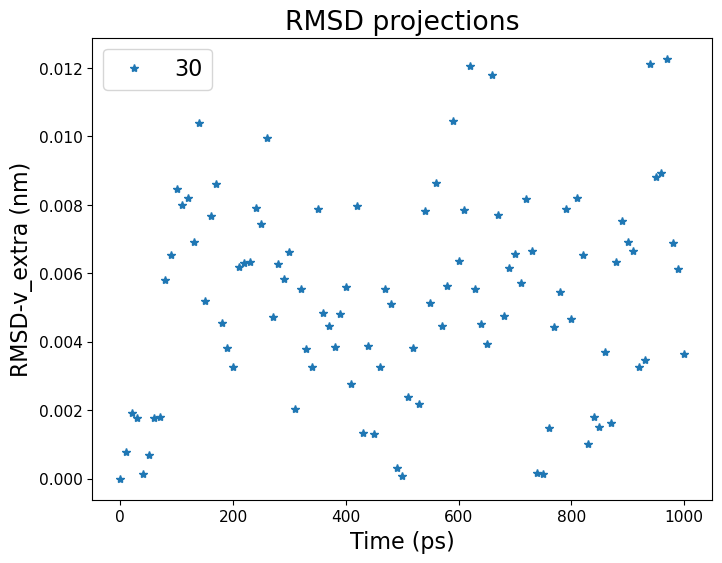

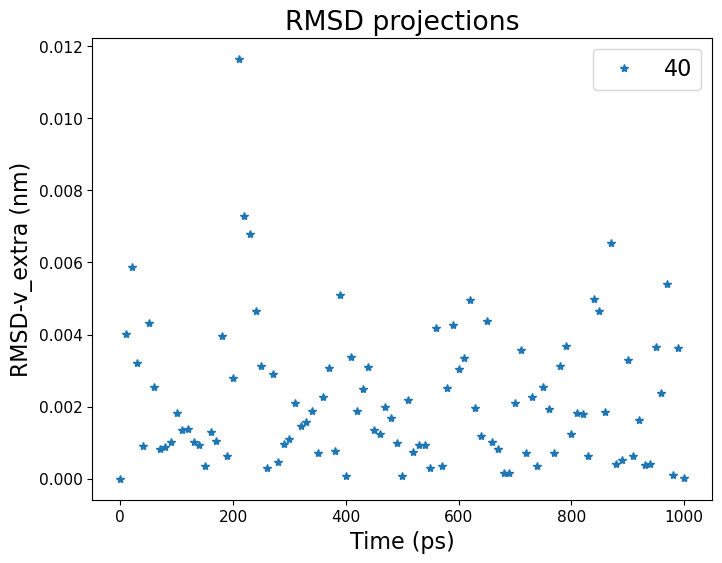

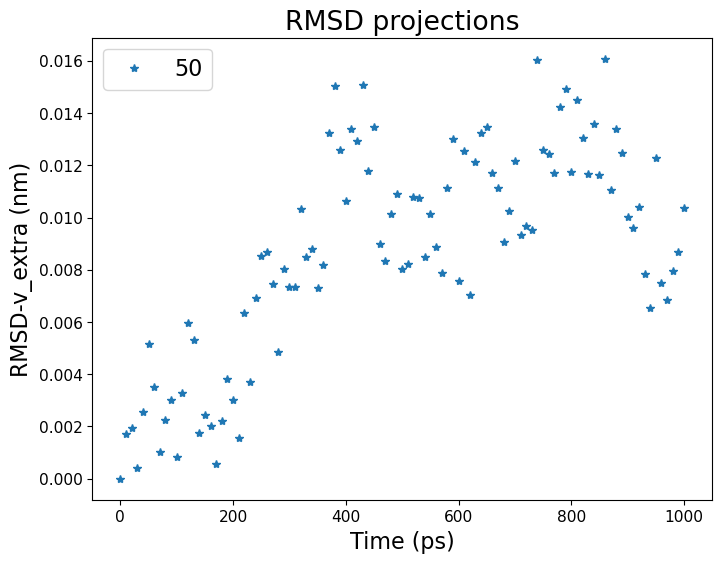

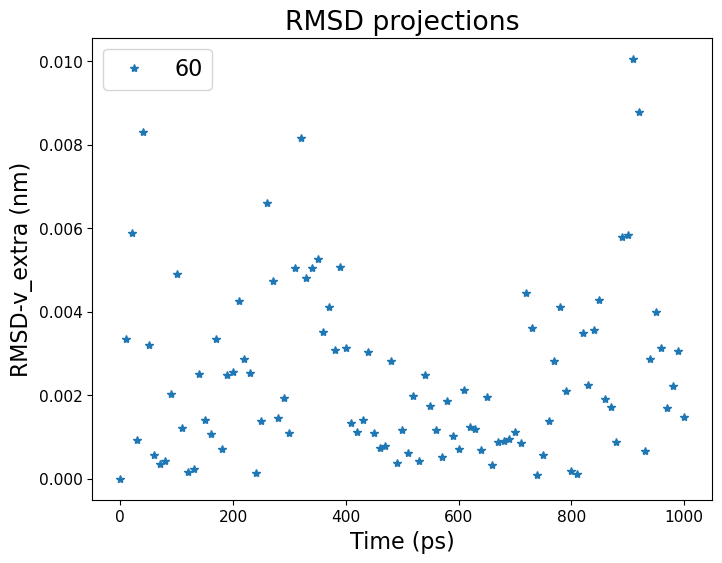

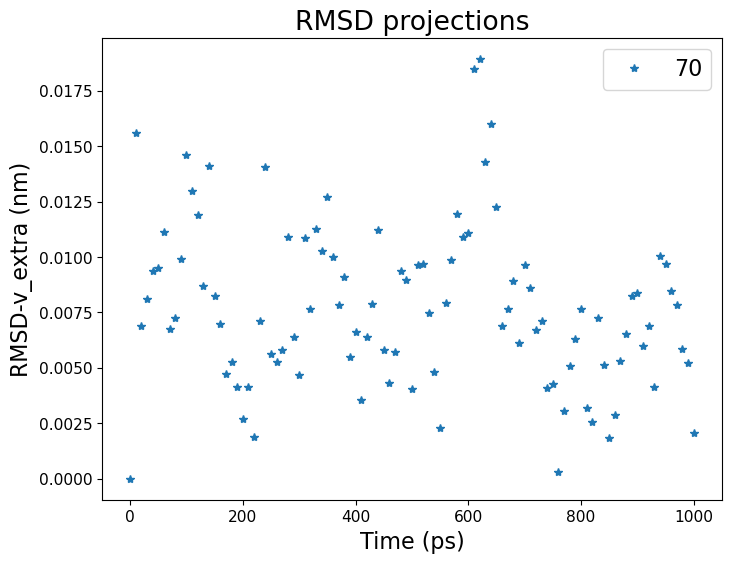

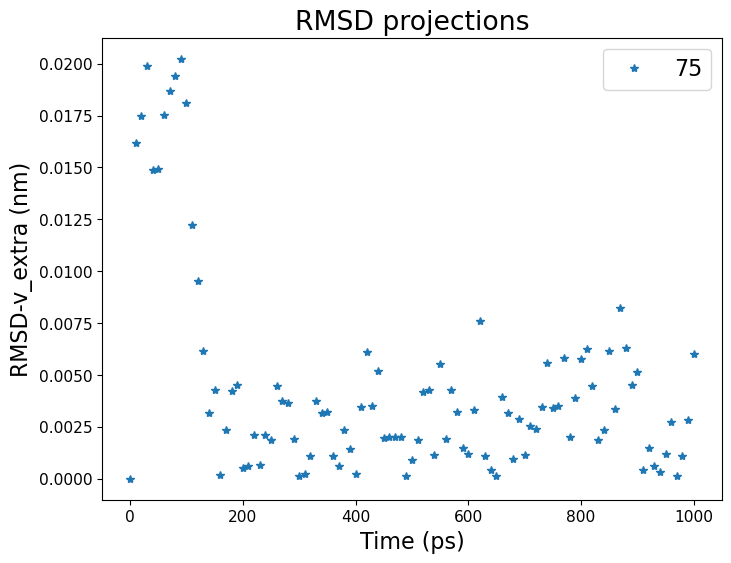

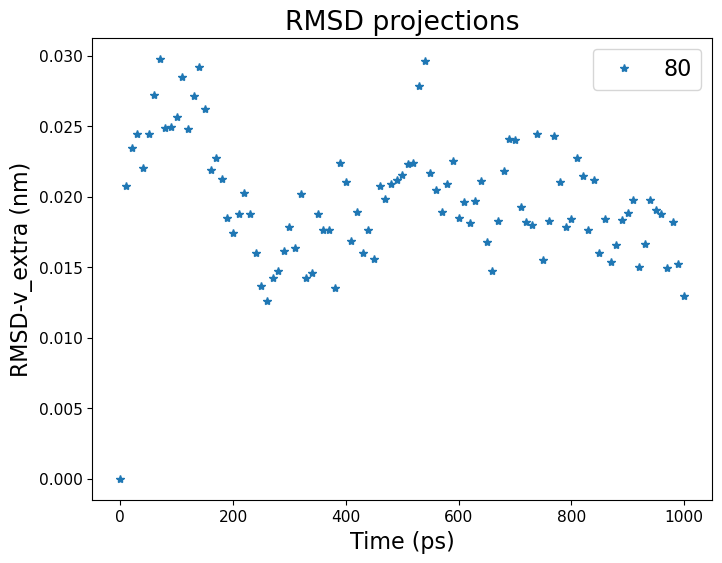

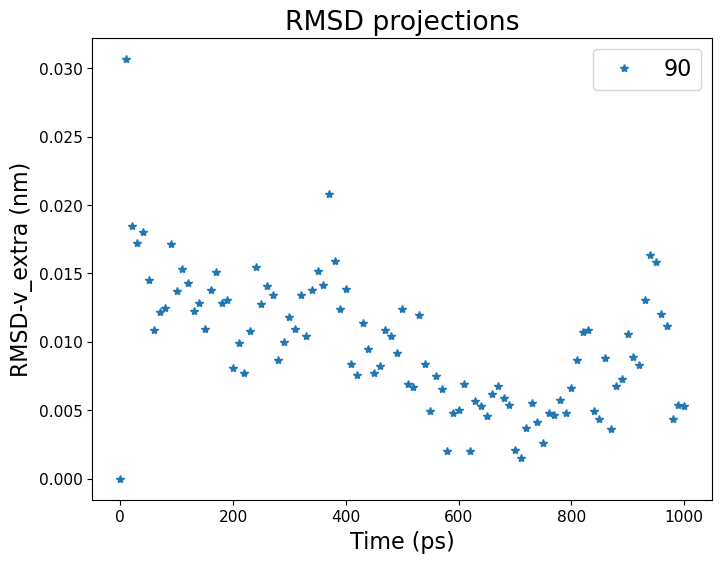

In [67]:
delT = [10, 20, 30, 40, 50, 60, 70, 75, 80, 90]
prmsd = []
time = [i*10 for i in range(101)]
for k in range(len(delT)):
    pdb_mdenm = file_dir+"withlambda_{}_delT/pdb_mdenm.pdb".format(delT[k])
    xtc_mdenm = file_dir+"withlambda_{}_delT/xtc_mdenm.xtc".format(delT[k])
    pdb_ref = file_dir+"pdb_ref.pdb"
    z_v = [residue_displacement(pdb_mdenm, xtc_mdenm, pdb_ref, '(chainID A or chainID B) and name CA', Um, delT[k])]
    z_v = z_v[0]
    z_v = [i*0.1 for i in (z_v)]
    prmsd.append(z_v)
    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = '16'
    plt.plot(time, z_v, '*')
    plt.title('RMSD projections')
    plt.xlabel('Time (ps)')
    plt.ylabel('RMSD-v_extra (nm)')
    plt.legend([str(delT[k])])

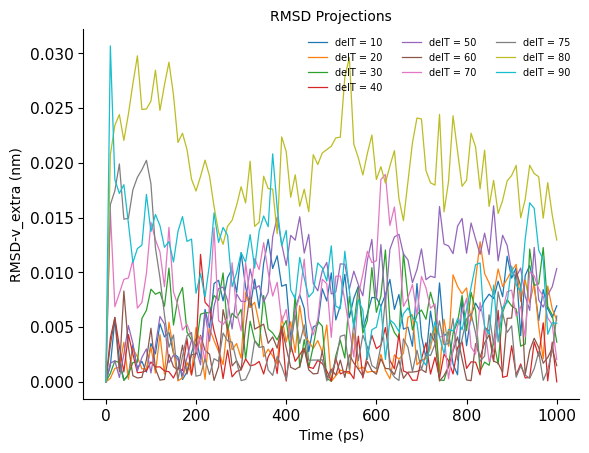

In [68]:
time = [i*10 for i in range(101)]
fig, ax = plt.subplots()
for k in range(len(delT)): 
    ax.plot(time, prmsd[k], label = 'delT = {}'.format(str(delT[k])), linewidth = 0.9)
    ax.legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':7})
    ax.set_xlabel('Time (ps)', fontsize = 10)
    ax.set_ylabel('RMSD-v_extra (nm)', fontsize = 10)
#    ax.set_ylim(0, 0.09)
    ax.set_title('RMSD Projections', fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.show()

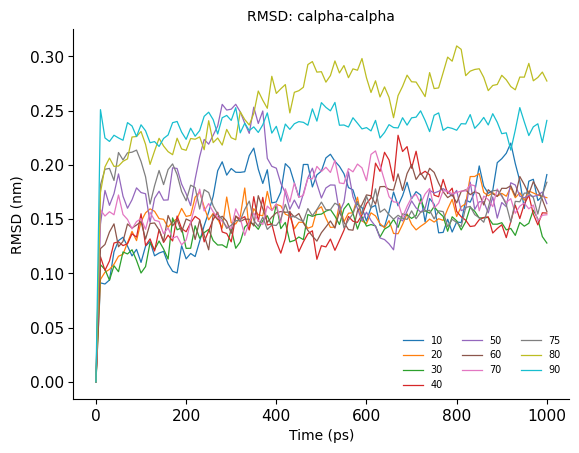

In [69]:
rmsd = []
fig, ax = plt.subplots()
for k in range(len(delT)):
    filename = file_dir+"withlambda_{}_delT/rmsd_calpha_calpha.xvg".format(delT[k])
    rmsd_value = np.genfromtxt(filename, skip_header = 18)
    rmsd.append(rmsd_value[:, 1])
    ax.plot(rmsd_value[:, 0], rmsd_value[:, 1], label = str(delT[k]), linewidth = 0.9)
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
ax.set_xlabel("Time (ps)", fontsize = 10)
ax.set_ylabel("RMSD (nm)", fontsize = 10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("RMSD: calpha-calpha", fontsize = 10)
plt.legend(frameon = False, loc='lower right', ncol = 3, prop={'size':7})

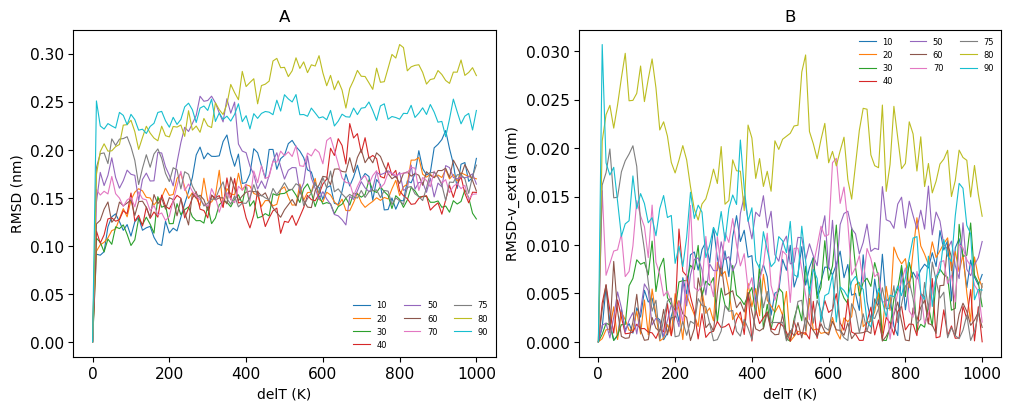

In [70]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for k in range(len(delT)):
    axes[0].plot(time, rmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[0].set_xlabel("delT (K)", fontsize = 10)
    axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
    axes[0].set_title("A", fontsize = 12)
    axes[0].legend(frameon = False, loc ="lower right", ncol = 3, prop={'size':6})
    axes[1].plot(time, prmsd[k], label = str(delT[k]), linewidth = 0.8)
    axes[1].set_xlabel("delT (K)", fontsize = 10)
    axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
    axes[1].set_title("B", fontsize = 12)
#    axes[1].set_ylim(0, 0.09)
    axes[1].legend(frameon = False, loc ="upper right", ncol = 3, prop={'size':6})

Text(0.5, 1.0, 'B')

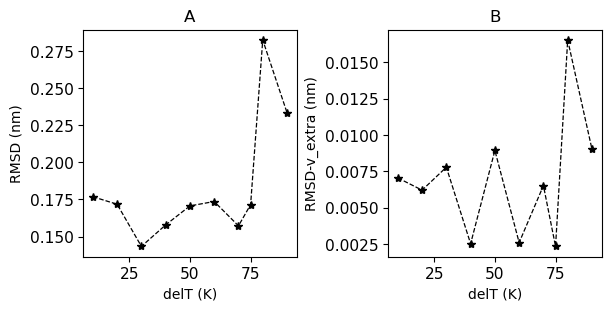

In [71]:
avg_rmsd = []
avg_prmsd = []
for k in range(len(delT)):
    avg_rmsd.append(np.average(rmsd[k][95:]))
    avg_prmsd.append(np.average(prmsd[k][95:]))

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout='constrained')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

axes[0].plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[0].set_xlabel("delT (K)", fontsize = 10)
axes[0].set_ylabel("RMSD (nm)", fontsize = 10)
axes[0].set_title("A", fontsize = 12)
axes[1].plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'black', linewidth = 0.9)
axes[1].set_xlabel("delT (K)", fontsize = 10)
axes[1].set_ylabel("RMSD-v_extra (nm)", fontsize = 10)
axes[1].set_title("B", fontsize = 12)
    
# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_rmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD (nm)", fontsize = 14)
# plt.title("Average RMSD wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# fig, ax = plt.subplots()
# plt.rc('font', family='sans-serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.plot(delT, avg_prmsd, '*', linestyle='dashed', color = 'grey')
# plt.xlabel("delT (K)", fontsize = 14)
# plt.ylabel("RMSD-v_extra (nm)", fontsize = 14)
# plt.title("Average RMSD projections wrt delT", fontsize = 14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)